In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
#import contextily as ctx
import geopandas as gpd
import os
import seaborn as sns

#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from PIL import Image
#from matplotlib.colors import rgb2hex
#from matplotlib.patches import Patch, Circle


import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
hospital_data_to_load = Path("data/analysis_data.csv")
#telehealth_to_load = Path("../data_folder/telehealth_2023.csv")
states = gpd.read_file("data/usa-states-census-2014.shp")


# Read School and Student Data File and store into Pandas DataFrames
analysis_data = pd.read_csv(hospital_data_to_load)
#local_data = pd.read_csv(telehealth_to_load, low_memory=False)

# Read shapefile using geopandas
states = states.to_crs("EPSG:3395")

In [2]:
# Rename column state to NAME to allow merge with map file
analysis_data_df=pd.DataFrame(analysis_data)
analysis_data_df.rename(columns={"state": "NAME"}, inplace=True)
analysis_data_df.head()

Year        NAME  State_Pct_Telehealth  Rural_Pct_Telehealth  \
0  2023     Alabama                0.0713                0.0661   
1  2023      Alaska                0.1580                0.1682   
2  2023     Arizona                0.1549                0.1526   
3  2023    Arkansas                0.1070                0.0906   
4  2023  California                0.2743                0.2530   

   Urban_Pct_Telehealth                                                FID  \
0                0.0732  Connect2Health_2023_state.fid-1c4f9cde_18cec2a...   
1                0.1465  Connect2Health_2023_state.fid-1c4f9cde_18cec2a...   
2                0.1553  Connect2Health_2023_state.fid-1c4f9cde_18cec2a...   
3                0.1203  Connect2Health_2023_state.fid-1c4f9cde_18cec2a...   
4                0.2768  Connect2Health_2023_state.fid-1c4f9cde_18cec2a...   

   fips  County Population  County Pop Per Sq Mile  \
0     1            4903185                   96.80   
1     2             731545                    1.28   
2     4            7278717                   64.08   
3     5            3017804                   57.99   
4     6           39512223                  253.64   

   Fixed Internet Subscribers  ...  Number of PCPs per 100k  \
0                          75  ...                    65.00   
1                          80  ...                    94.32   
2                          85  ...                    64.68   
3                          67  ...                    66.27   
4                          89  ...                    79.87   

   Number of Dentists per 100k  Number of Mental Health per 100k  \
0                        49.89                            108.30   
1                       102.25                            499.63   
2                        63.03                            140.19   
3                        47.55                            236.36   
4                        87.02                            373.39   

   Number of Adults in poor or Fair health  Rural Population  \
0                                  1048095           2024944   
1                                   113872            262036   
2                                  1355532            922084   
3                                   702297           1342675   
4                                  6959513           2415048   

  Share of Pop in Rural Area  Urban Population Share of Pop in Urban Area  \
0                       41.3           2878241                       58.7   
1                       35.8            469509                       64.2   
2                       12.7           6356633                       87.3   
3                       44.5           1675129                       55.5   
4                        6.1          37097175                       93.9   

   Number of Drug Related Deaths per 100k  \
0                                    16.5   
1                                    17.1   
2                                    22.5   
3                                    14.5   
4                                    12.4   

   Number of Opiod Related Deaths per 100k  
0                                      7.9  
1                                     11.5  
2                                     13.9  
3                                      6.8  
4                                      5.8  

[5 rows x 45 columns]

(-7584089.987989127, 2726880.660958633, -1633665.7576533922, 4888301.46639382)

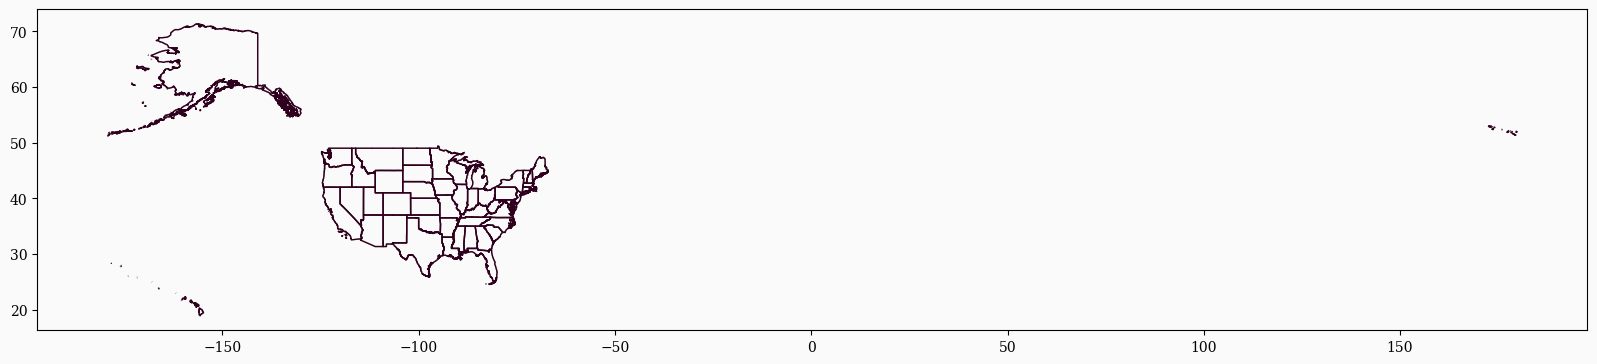

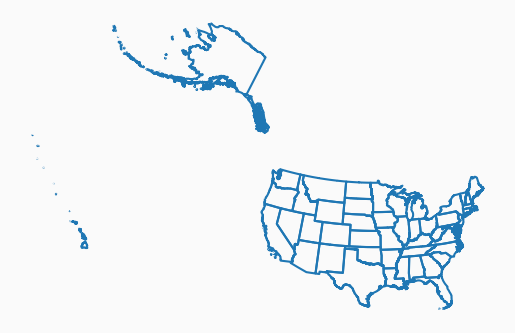

In [4]:
# Create map of the United States, move Alaska and Hawaii for presentation purposes

edge_color = "#30011E"
background_color = "#fafafa"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})


# Load and prepare geo-data
#counties = gpd.read_file("../data_folder/data/cb_2018_us_county_500k/")

#You do need to watch for things like plotting over the antimeridian (180 E)
# "~" means bitwise not, inversing boolean mask - Falses to Trues and Trues to Falses.
# counties = counties[~counties.STATEFP.isin(["72", "69", "60", "66", "78"])]
# counties = counties.set_index("GEOID")

#states = gpd.read_file("cb_2018_us_state_500k/")
states = gpd.read_file("data/cb_2018_us_state_500k/")

states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78"])]
#states = states[~states.STATEFP.isin(["0", "0", "20", "20", "20"])]

ax = states.plot(edgecolor=edge_color + "55", color="None", figsize=(20, 20))
#states.plot(edgecolor=edge_color, color="None", linewidth=1)
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

# To transform all points in all geometries in an active geometry column to a different coordinate reference system.  
#counties = counties.to_crs("ESRI:102003")
states = states.to_crs("ESRI:102003")

states.boundary.plot()


def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df


def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)
    
    return pd.concat([df_main_land, df_alaska, df_hawaii])

#counties = adjust_maps(counties)
states = adjust_maps(states)

plt.axis("off")

#plt.show()
#states.head()

In [5]:
# Merge map data with our presentation data frame
states = states.merge(analysis_data_df, on='NAME')
list(states.columns.values)


['STATEFP',
 'STATENS',
 'AFFGEOID',
 'GEOID',
 'STUSPS',
 'NAME',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry',
 'Year',
 'State_Pct_Telehealth',
 'Rural_Pct_Telehealth',
 'Urban_Pct_Telehealth',
 'FID',
 'fips',
 'County Population',
 'County Pop Per Sq Mile',
 'Fixed Internet Subscribers',
 'Type of Residential Connection - code, need to find what it means',
 'Share of Pop with NO PROVIDERS offering servcies at minimum FCC',
 'Number of Providers offering access to 50% + of pop',
 'Share of Pop at FCC Benchmark of Internet Access',
 'Share of Pop with access to most common download speed tier',
 'Most Common download speed tier',
 'Share of Pop with access to most common upload speed tier',
 'Most common upload speed tier',
 'Share of pop with Fixed Broadband Service FCC Minimum',
 'Share of pop with NO ACCESS To Fixed Broadband FCC Minimum',
 'Number of Dentists',
 'Preventable Hospital Stays per 100k Medicare Enrollees',
 '% Adults with Physical Inactivity',
 '% Adults with Excessive

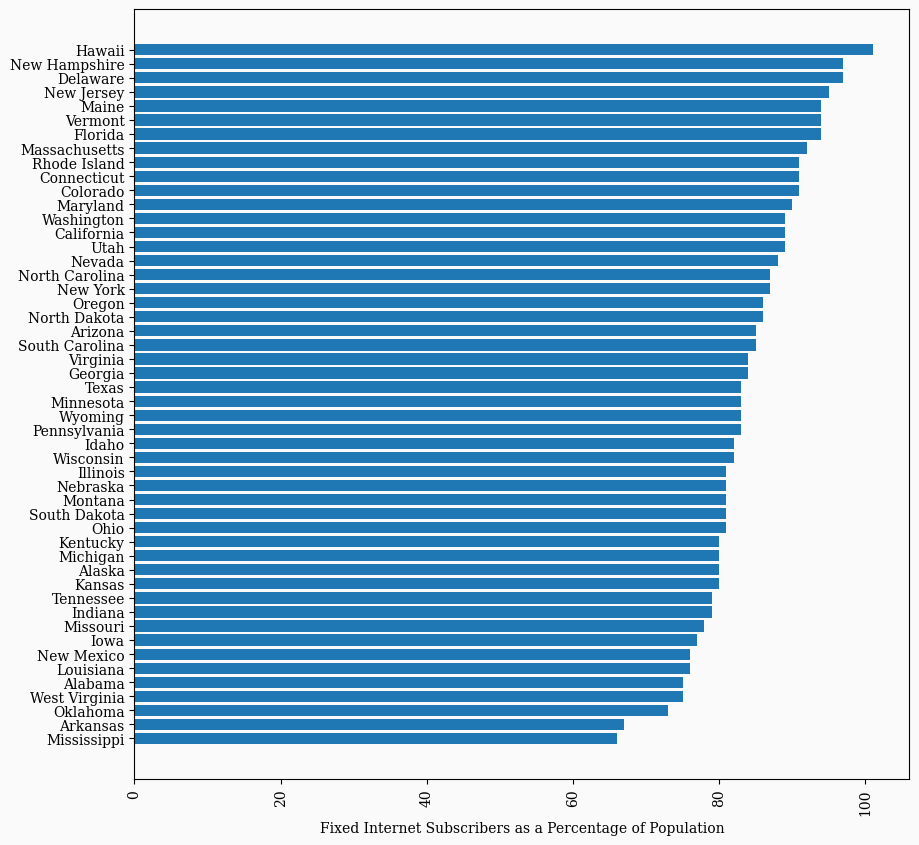

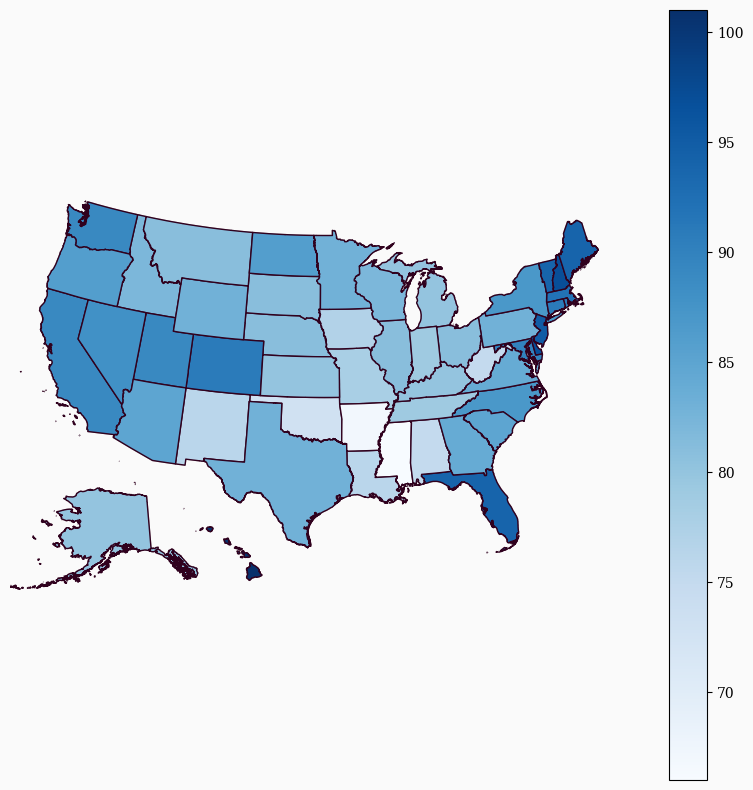

In [6]:
# graphs per state

#graphMe = 'State_Pct_Telehealth'
graphMe = "Fixed Internet Subscribers"

XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel("Fixed Internet Subscribers as a Percentage of Population")
plt.ylabel("")

plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(10, 10))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff",


ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

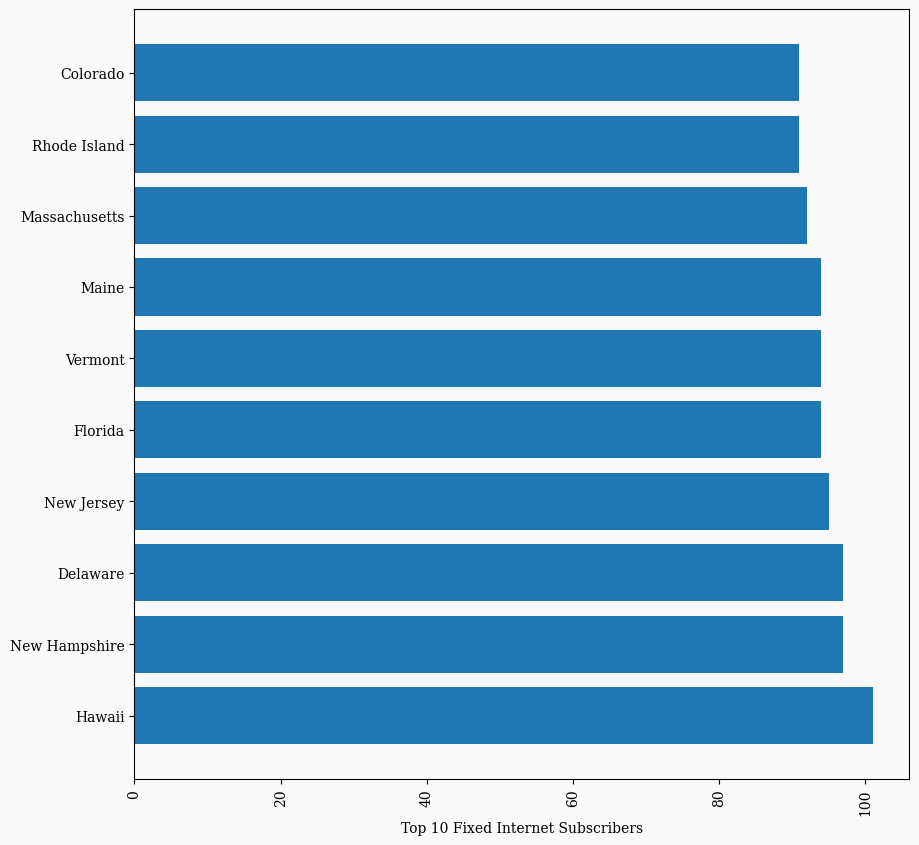

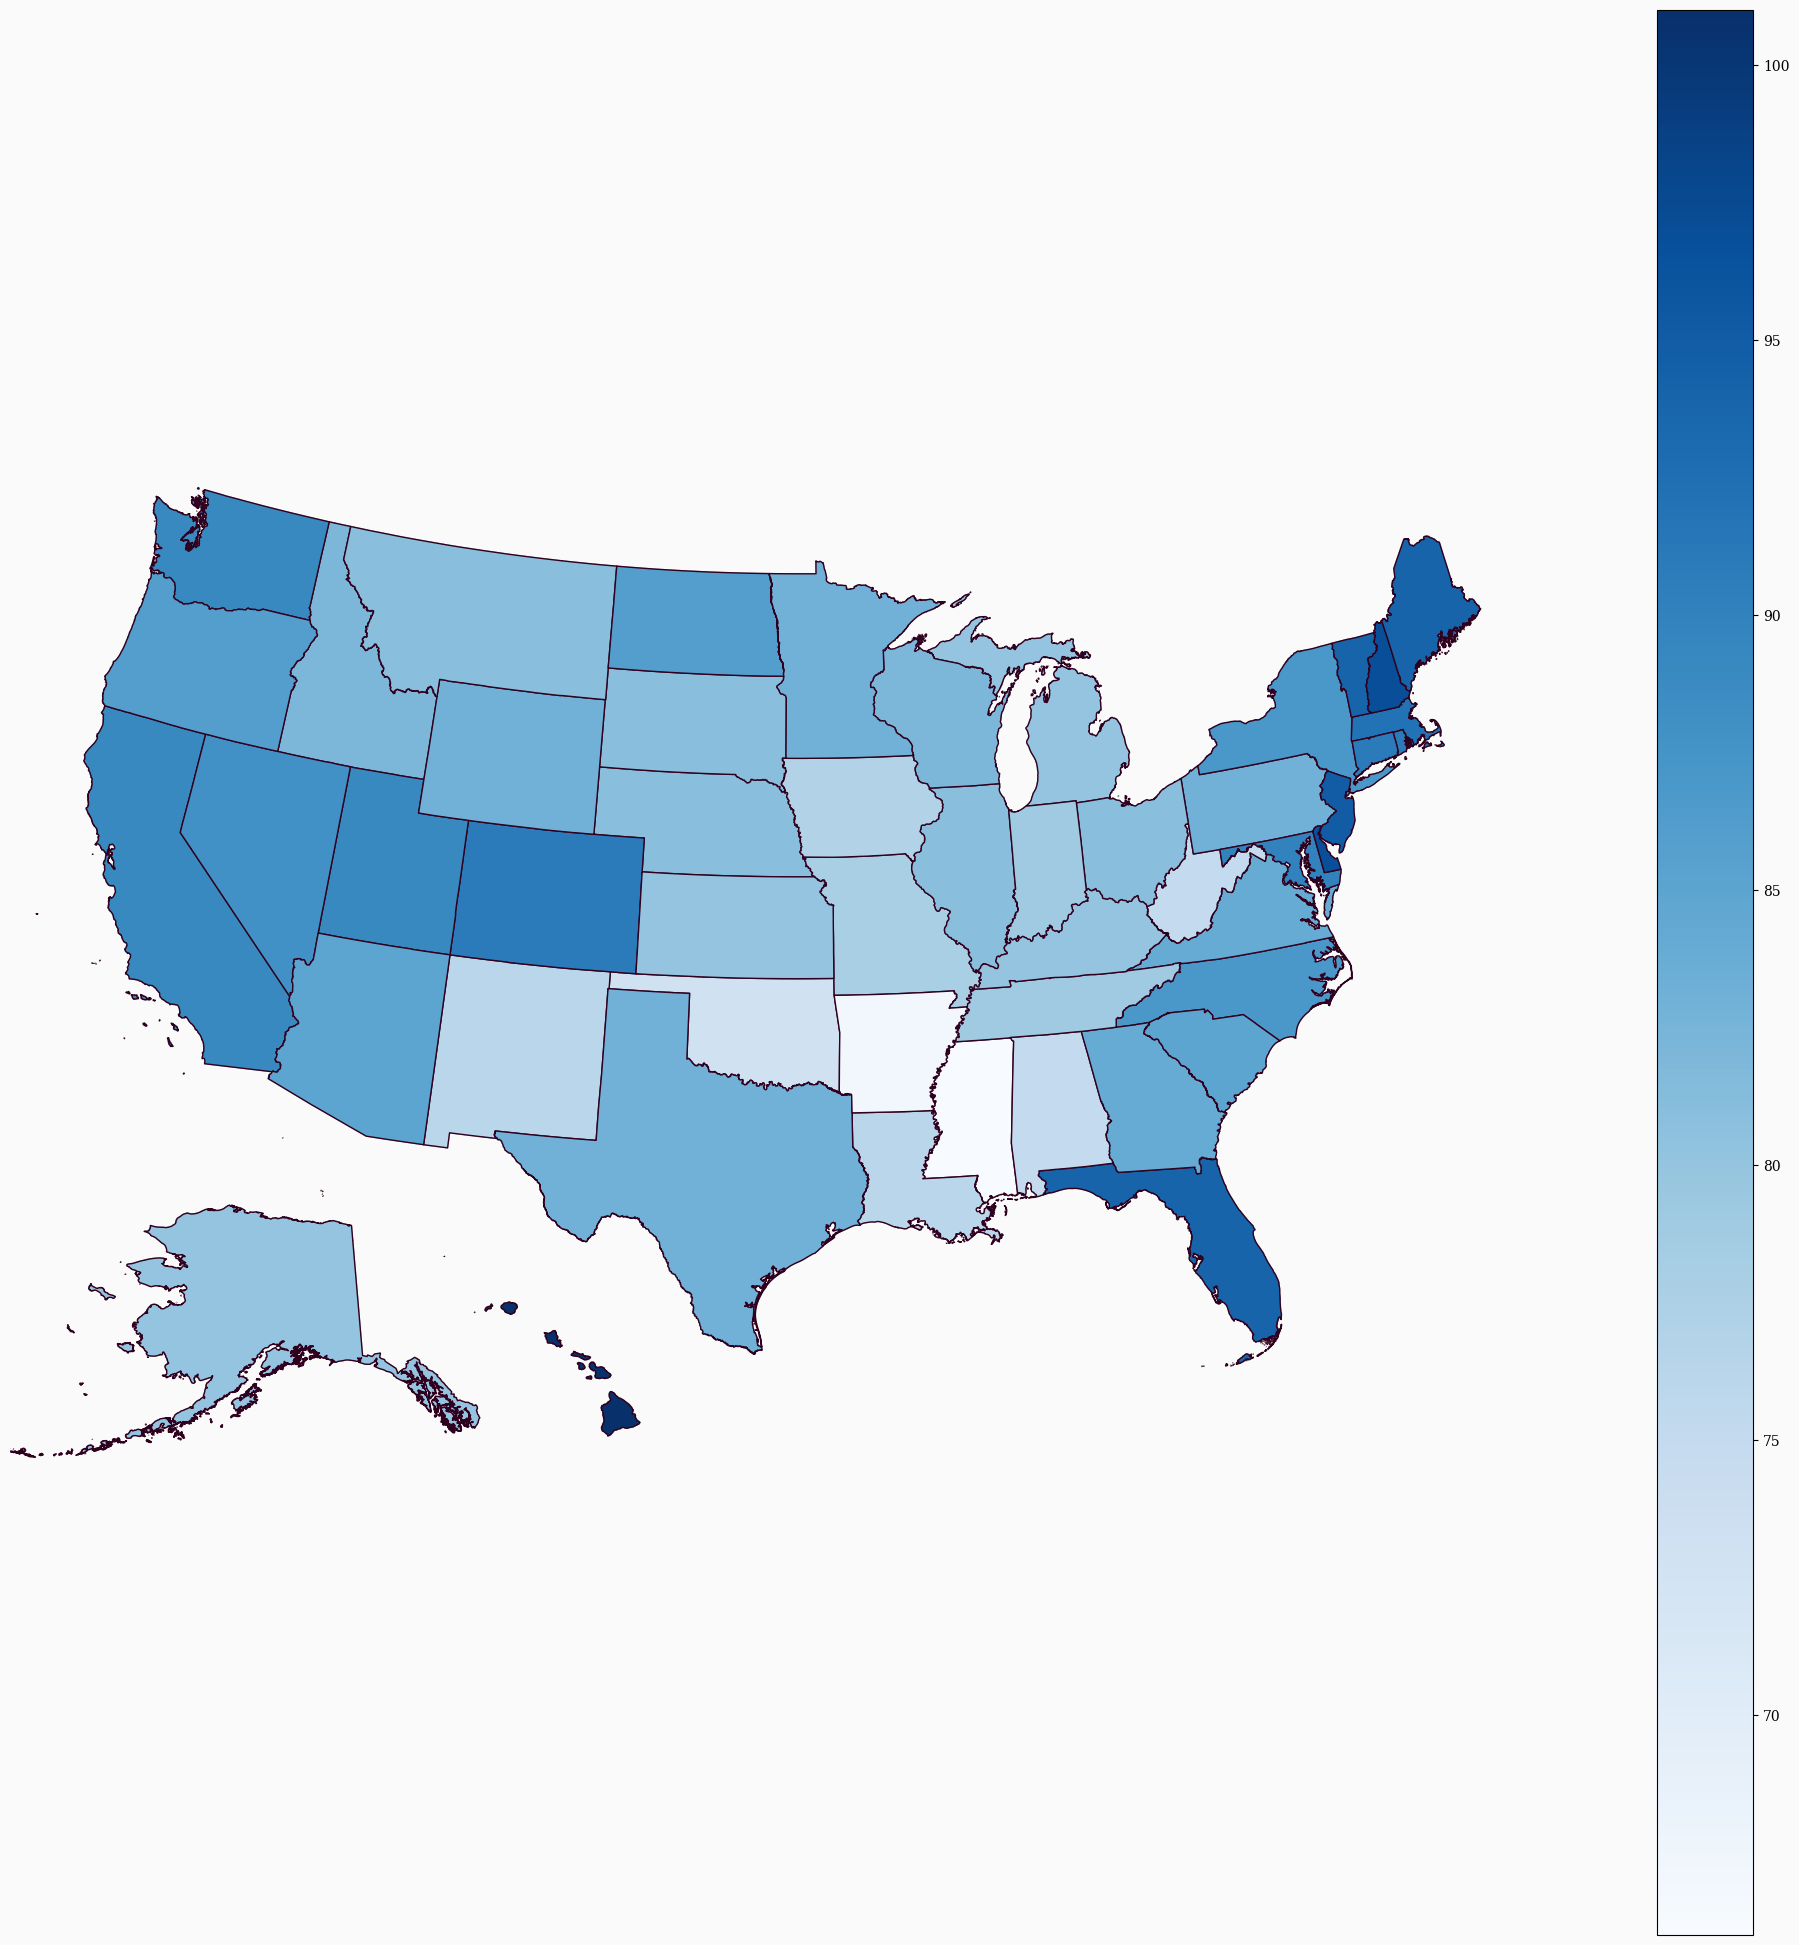

In [7]:
# TOP TEN
# graphs per state

graphMe = "Fixed Internet Subscribers"

XY = states[['NAME', graphMe]]

sortXY=XY.sort_values(graphMe, ascending=False)

graphXY = sortXY.head(10)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel("Top 10 Fixed Internet Subscribers")

plt.xticks(rotation=90, ha='center')
ax.set_title("Bottom Ten")
plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff", 
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

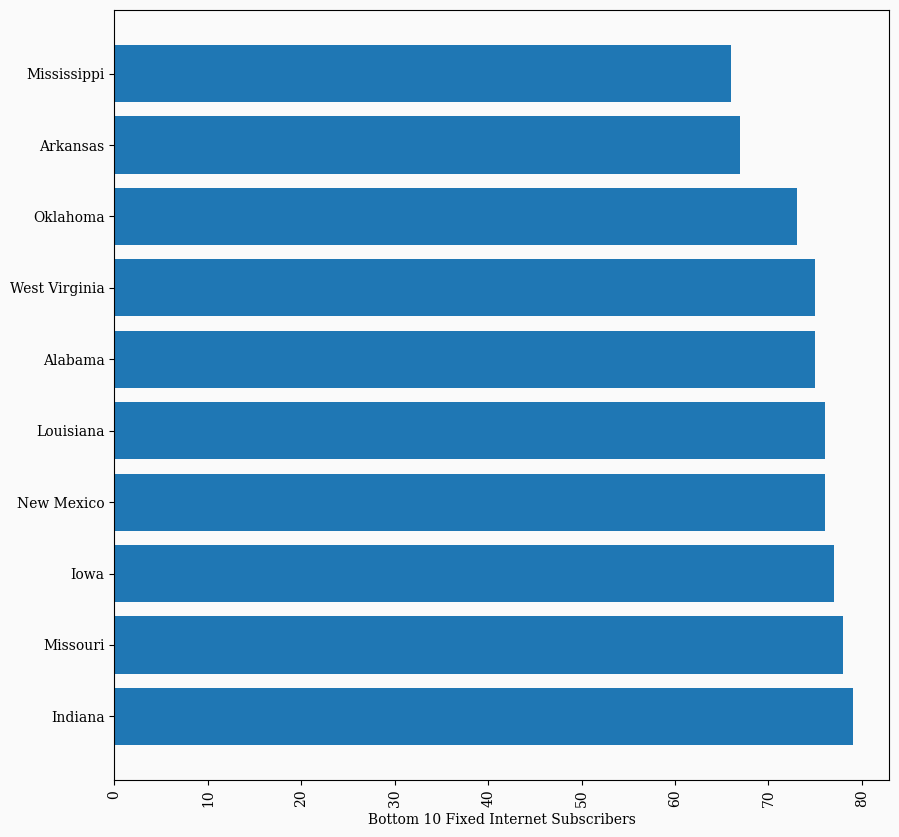

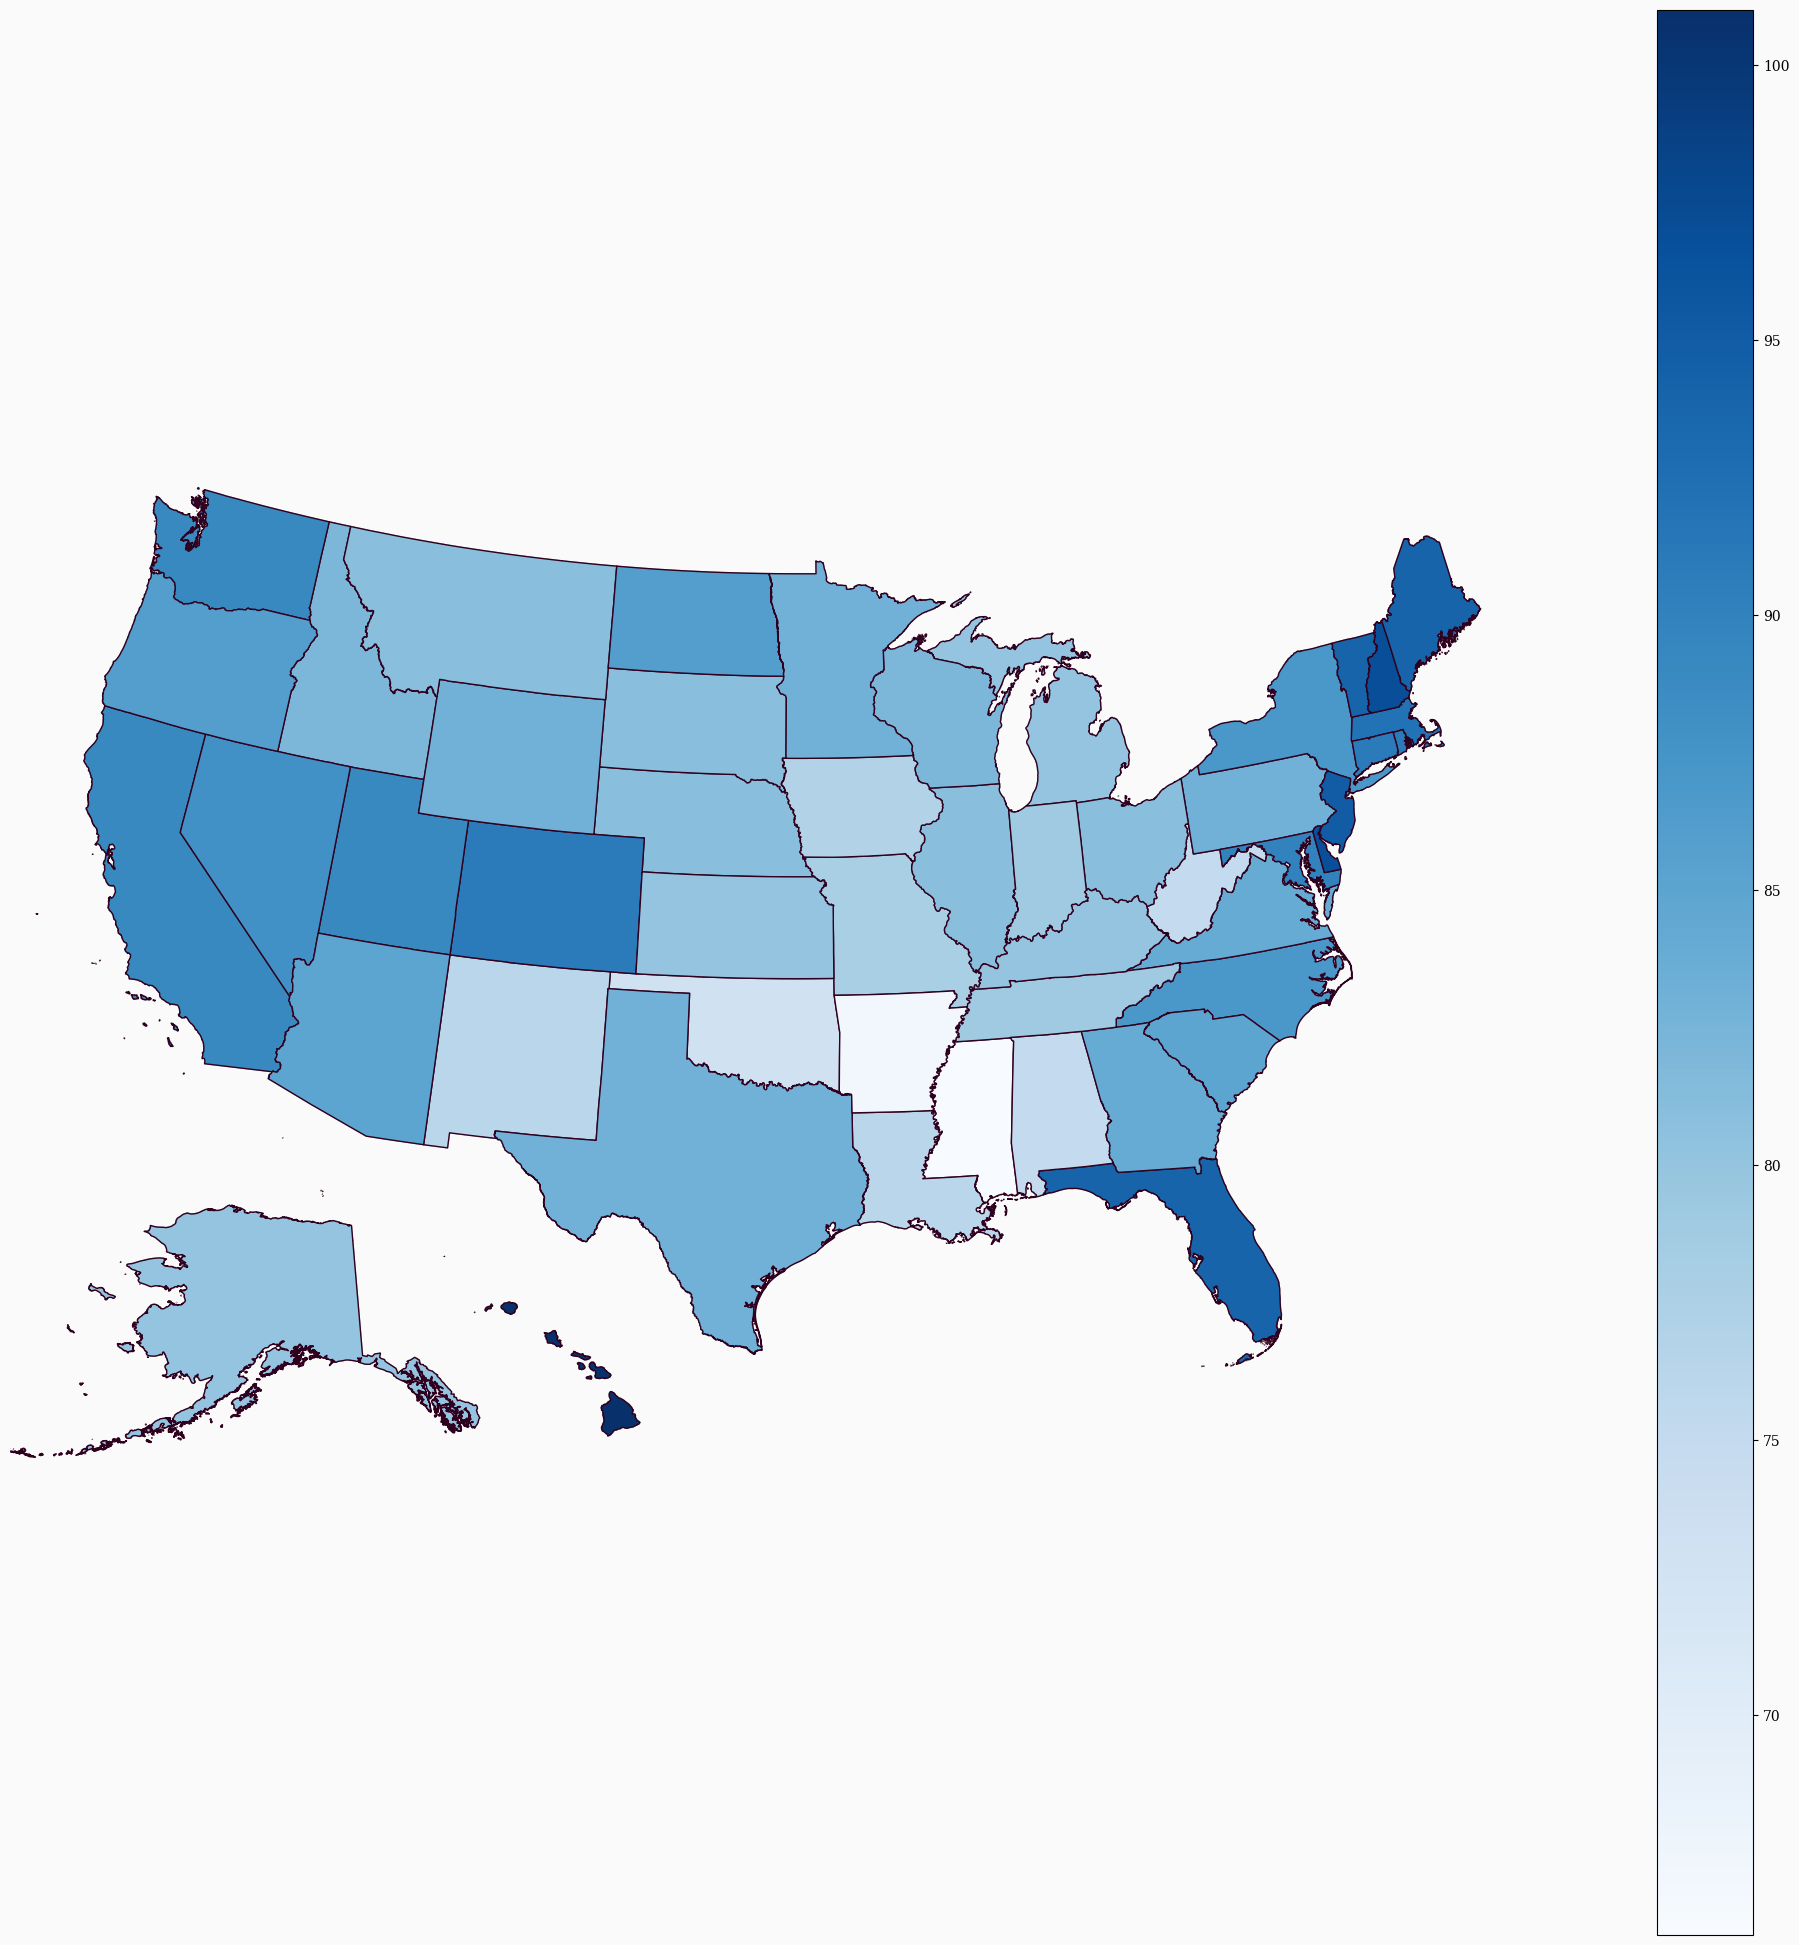

In [8]:
# BOTTOM TEN
# graphs per state

graphMe = "Fixed Internet Subscribers"

XY = states[['NAME', graphMe]]

sortXY=XY.sort_values(graphMe, ascending=False)

graphXY = sortXY.tail(10)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel("Bottom 10 Fixed Internet Subscribers")
plt.ylabel("")
plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________


ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff", 
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left



plt.axis("off")
plt.show()



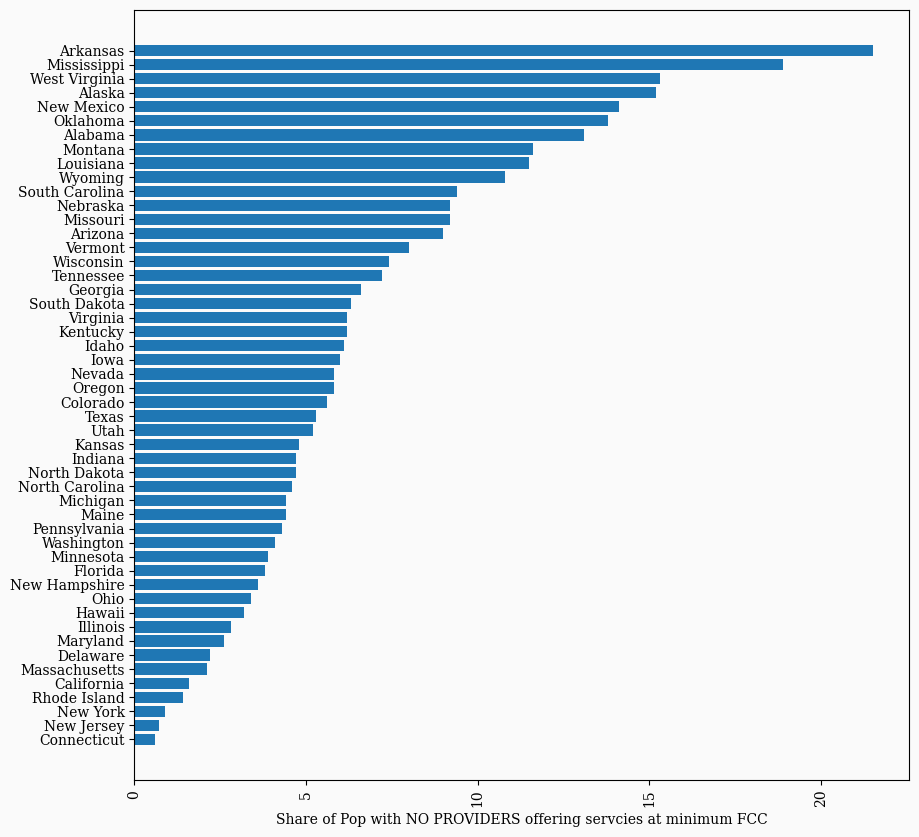

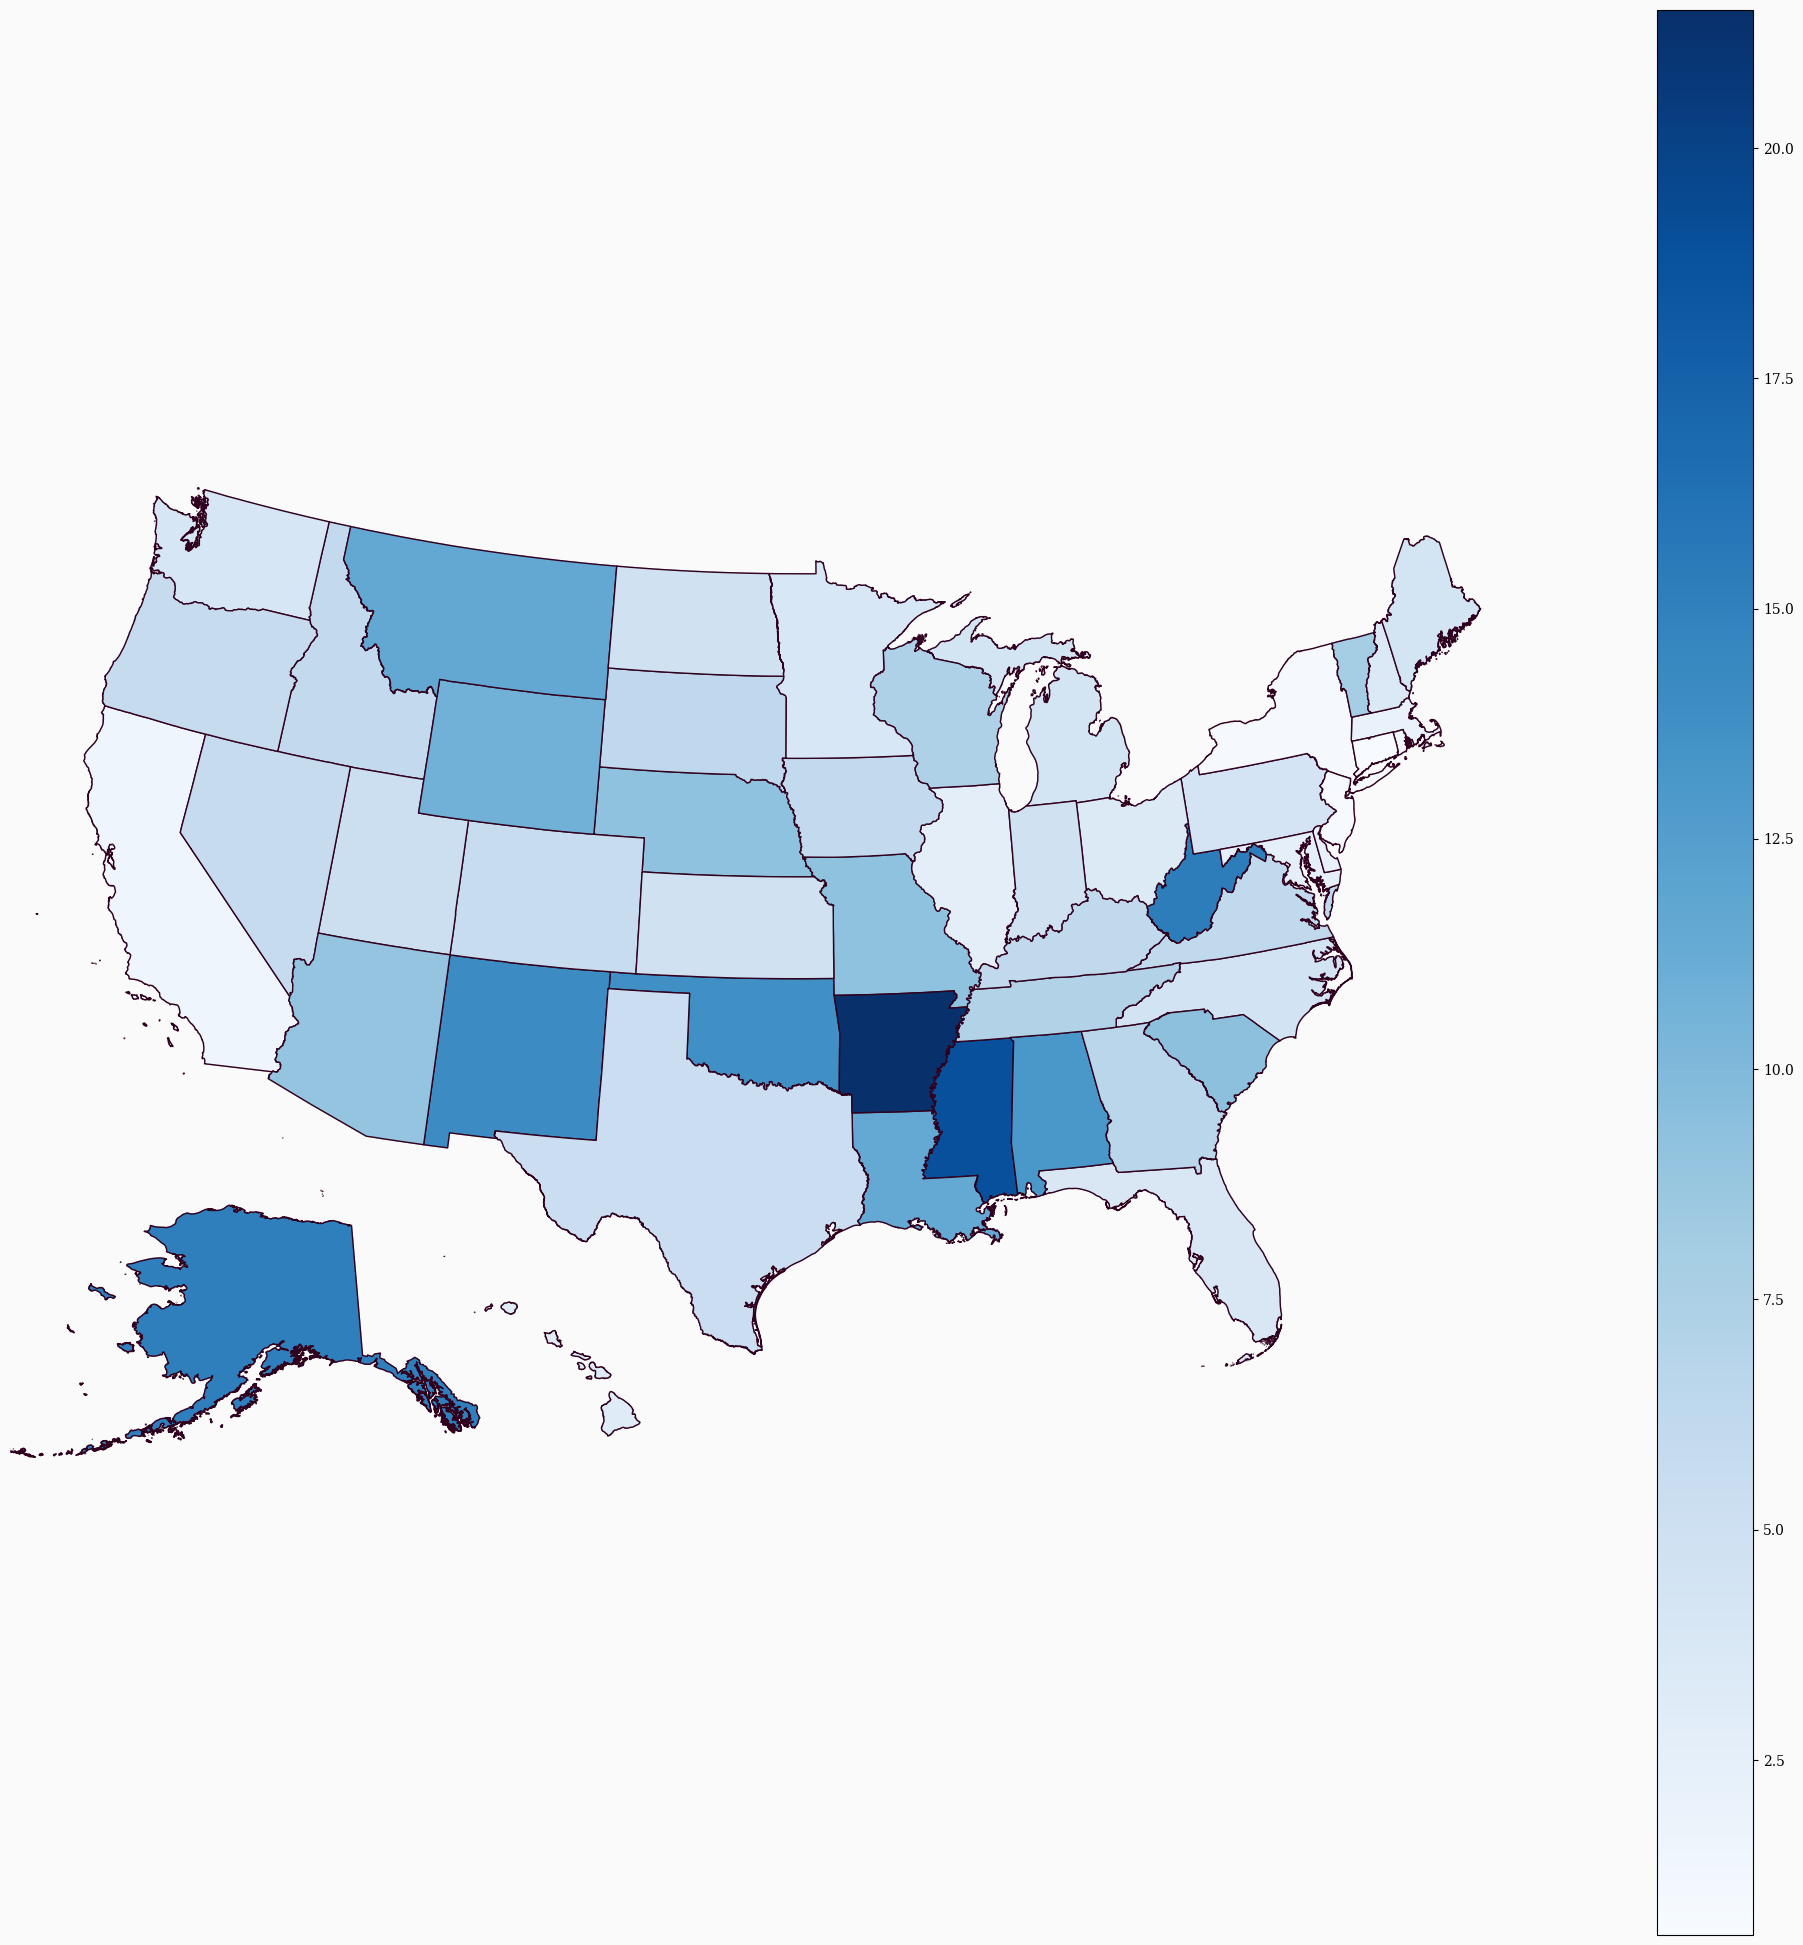

In [9]:

# graphs per state
graphMe = "Share of Pop with NO PROVIDERS offering servcies at minimum FCC"


XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel(graphMe)
plt.ylabel("")
plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________


ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff", 
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left



plt.axis("off")
plt.show()

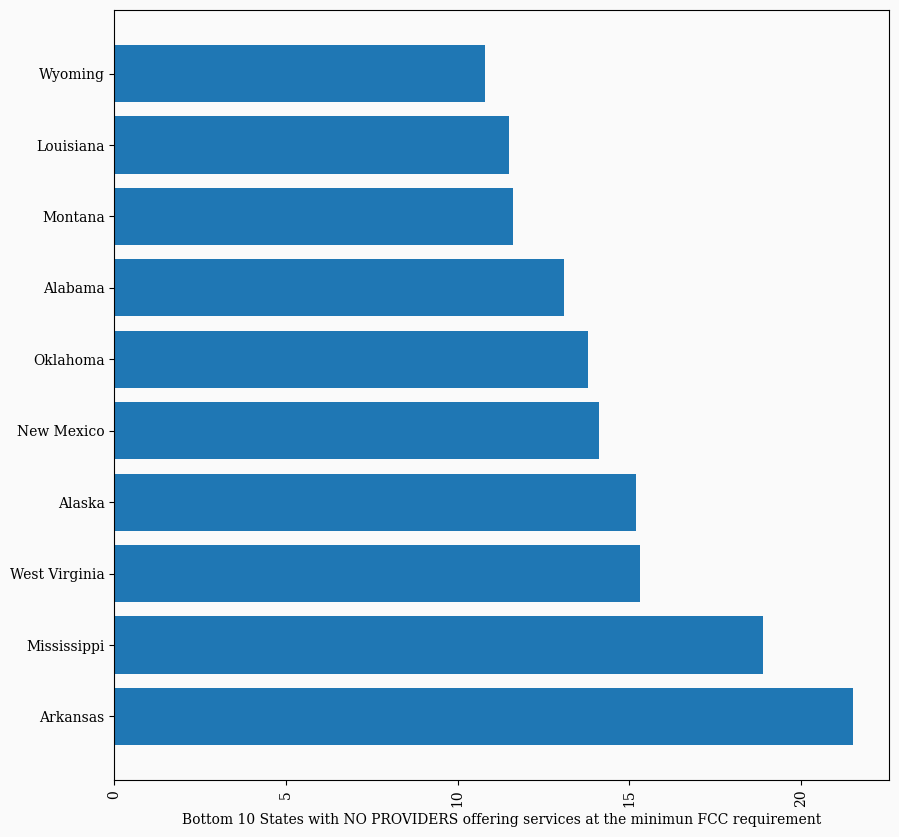

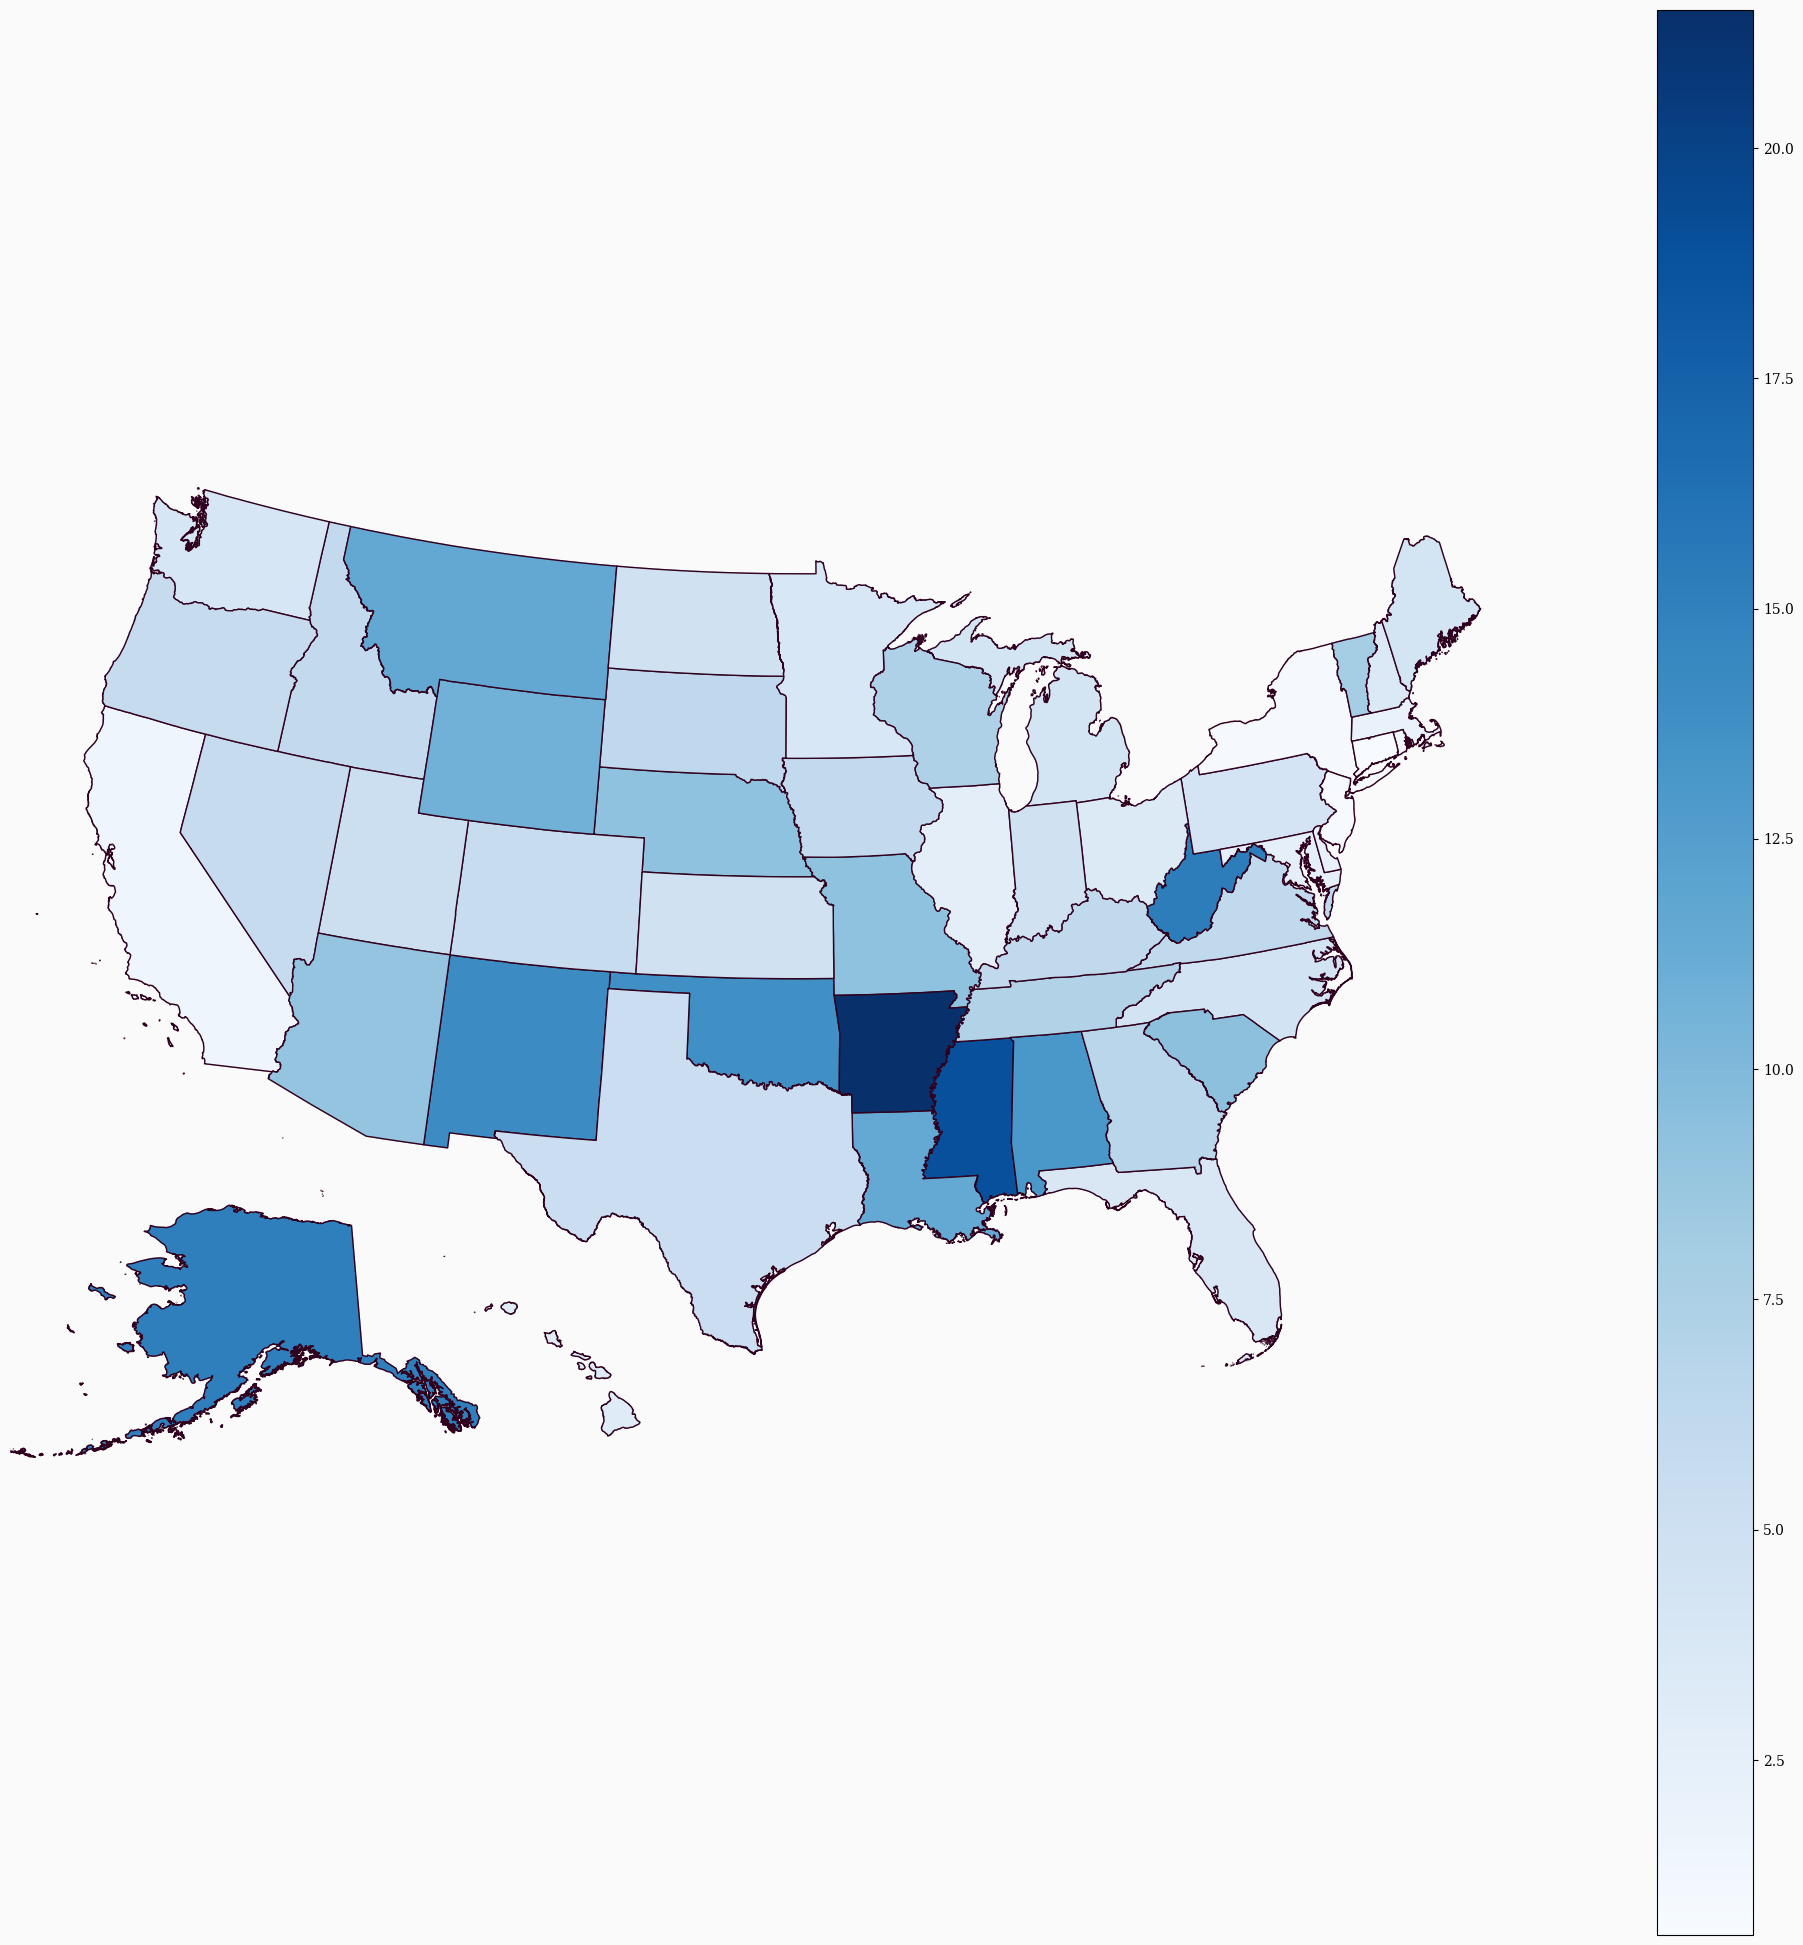

In [10]:
# TOP TEN
# graphs per state

graphMe = "Share of Pop with NO PROVIDERS offering servcies at minimum FCC"

XY = states[['NAME', graphMe]]

sortXY=XY.sort_values(graphMe, ascending=False)

graphXY = sortXY.head(10)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel("Bottom 10 States with NO PROVIDERS offering services at the minimun FCC requirement")

plt.xticks(rotation=90, ha='center')
ax.set_title("Bottom Ten")
plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff", 
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

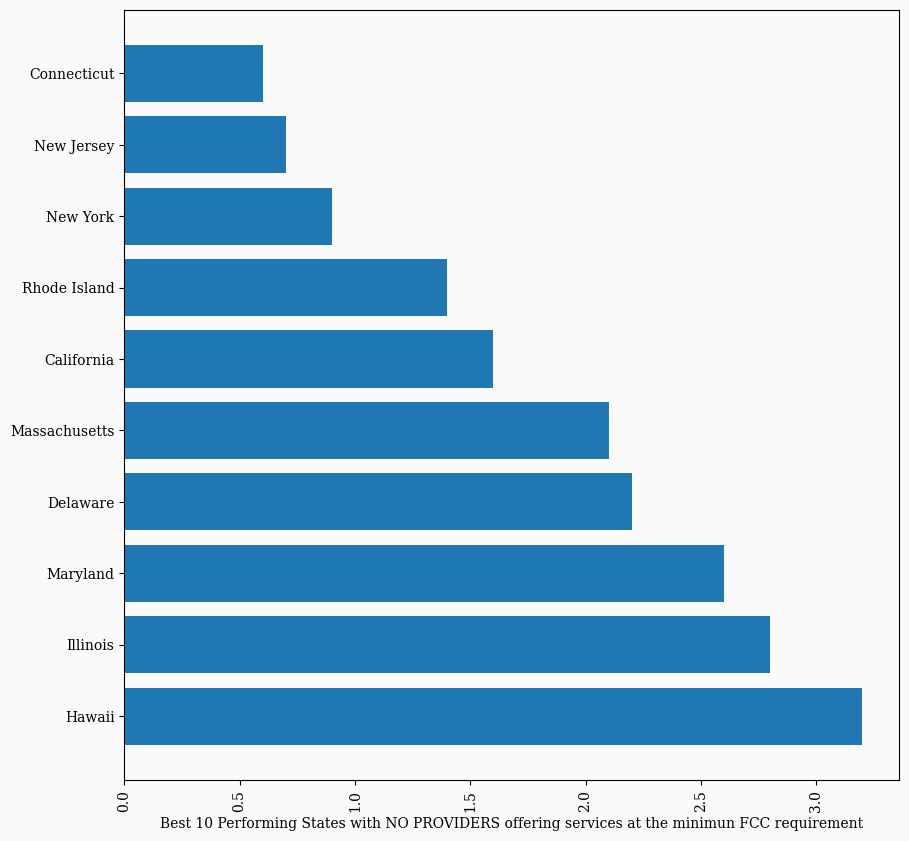

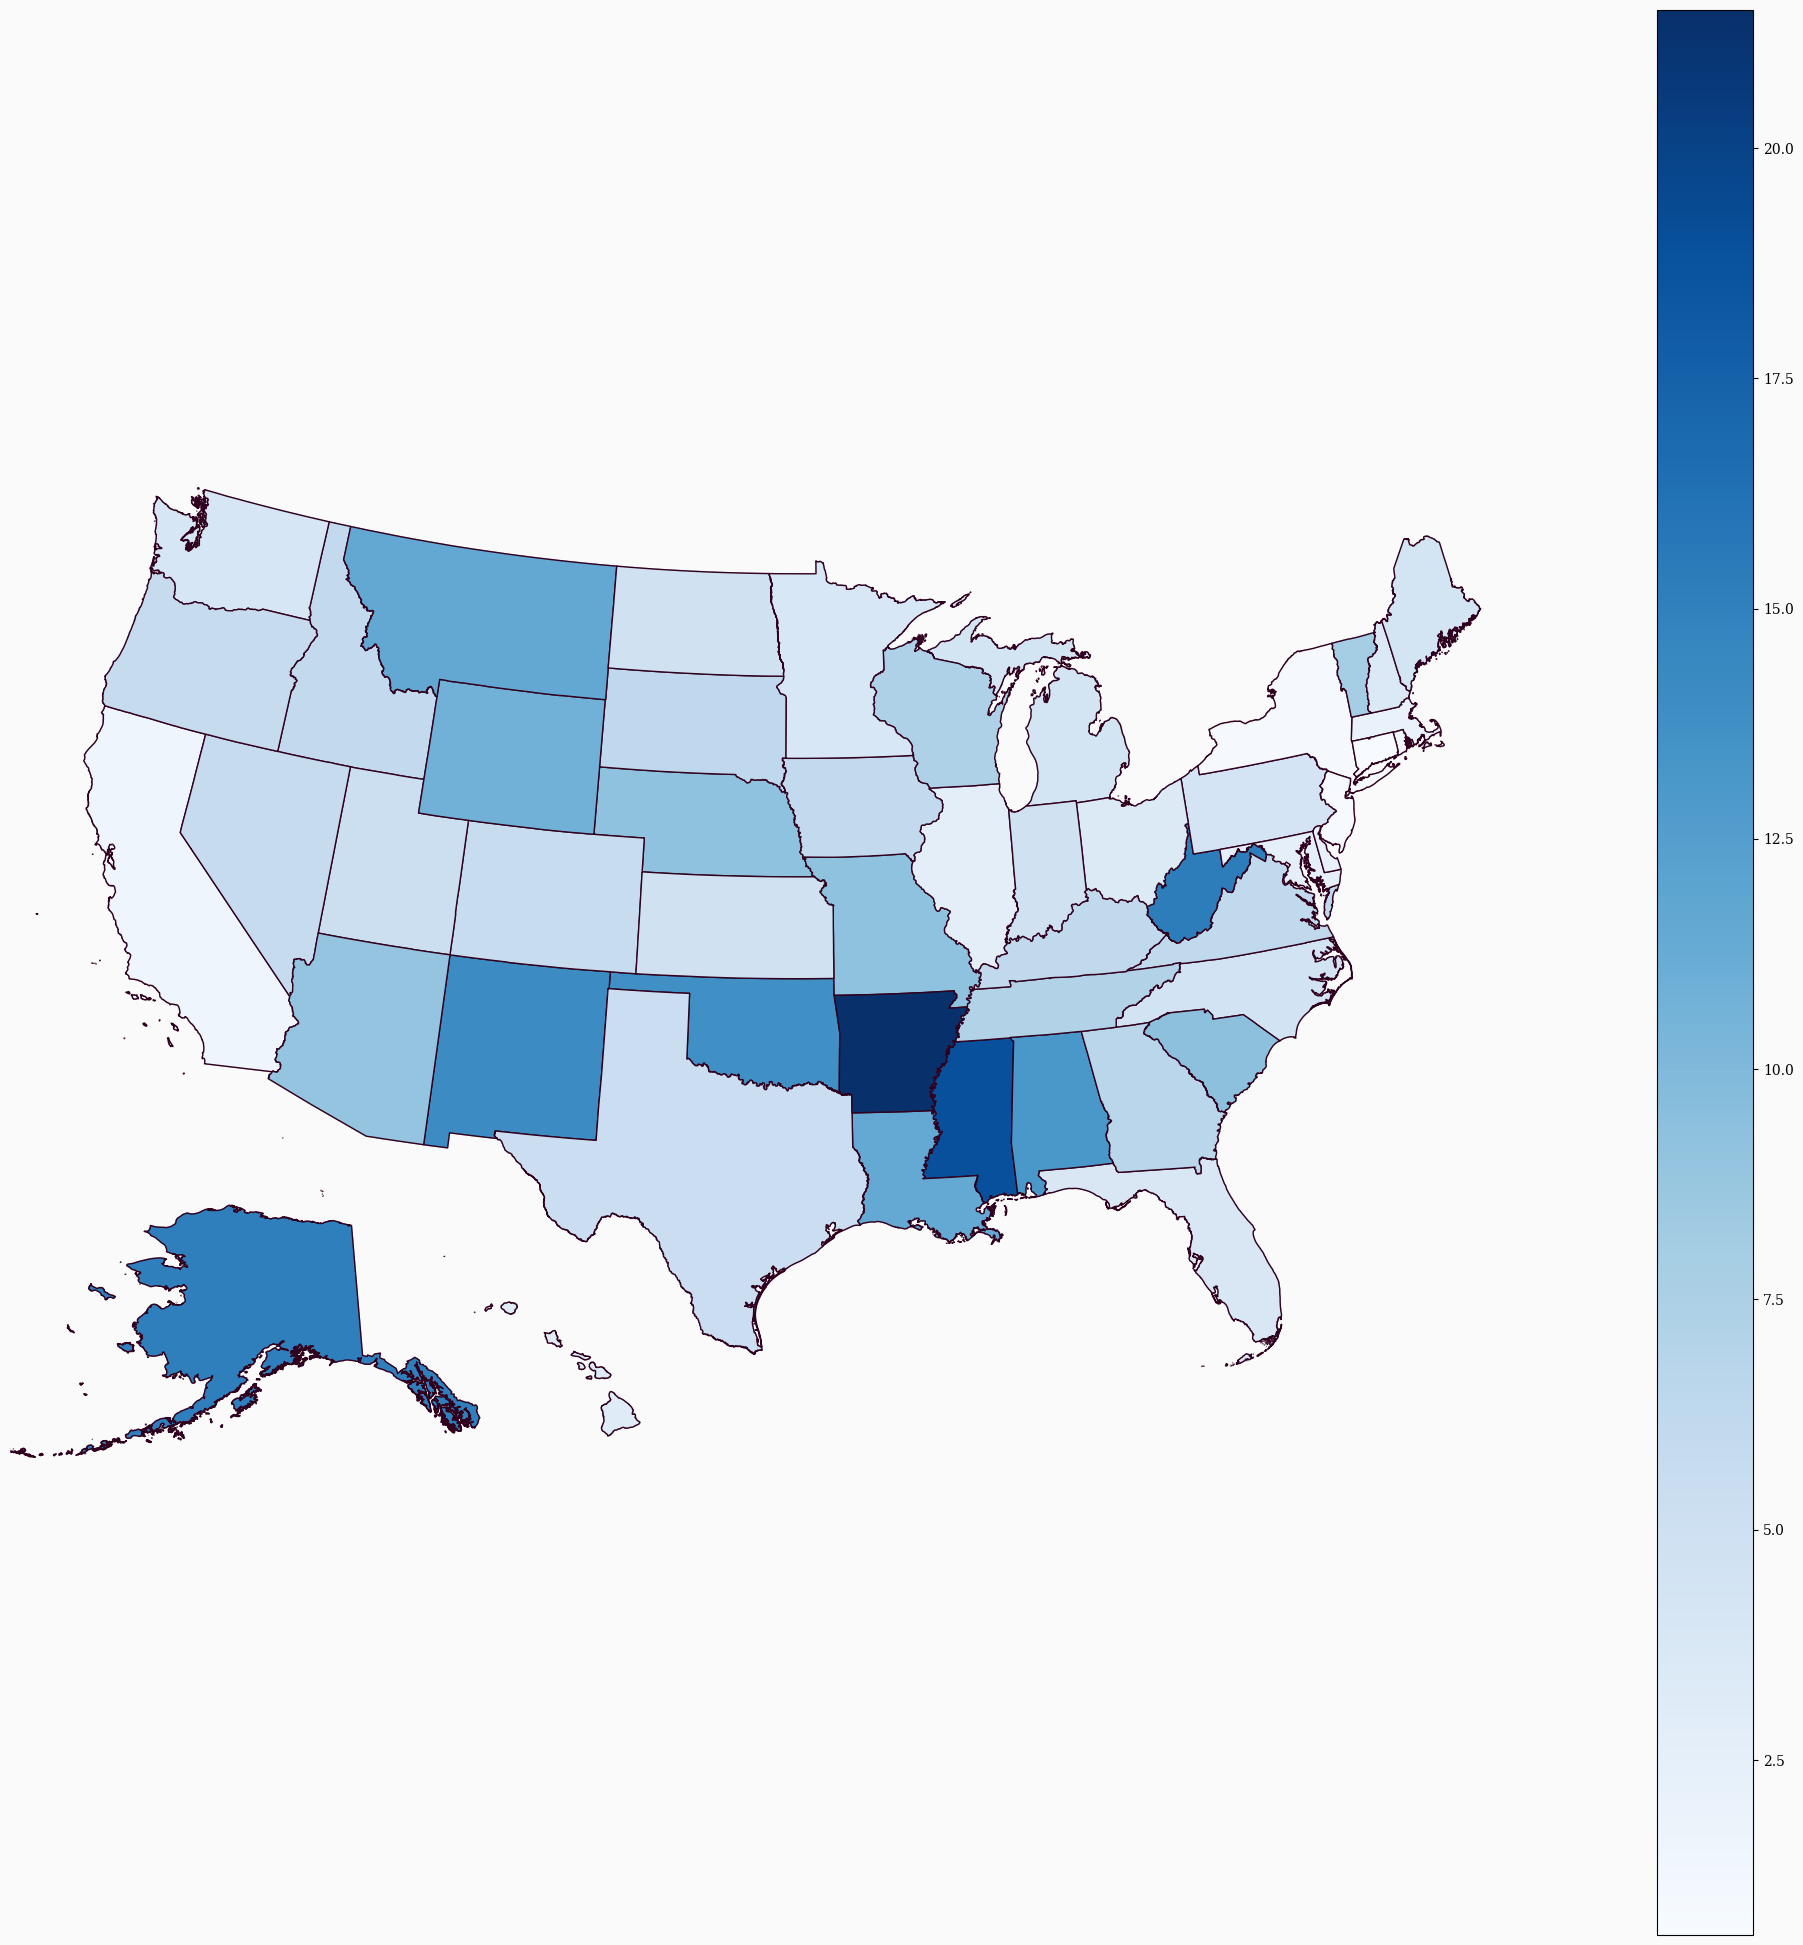

In [11]:
# BOTTOM TEN
# graphs per state

graphMe = "Share of Pop with NO PROVIDERS offering servcies at minimum FCC"

XY = states[['NAME', graphMe]]

sortXY=XY.sort_values(graphMe, ascending=False)

graphXY = sortXY.tail(10)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel("Best 10 Performing States with NO PROVIDERS offering services at the minimun FCC requirement")
plt.ylabel("")
plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________


ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff", 
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

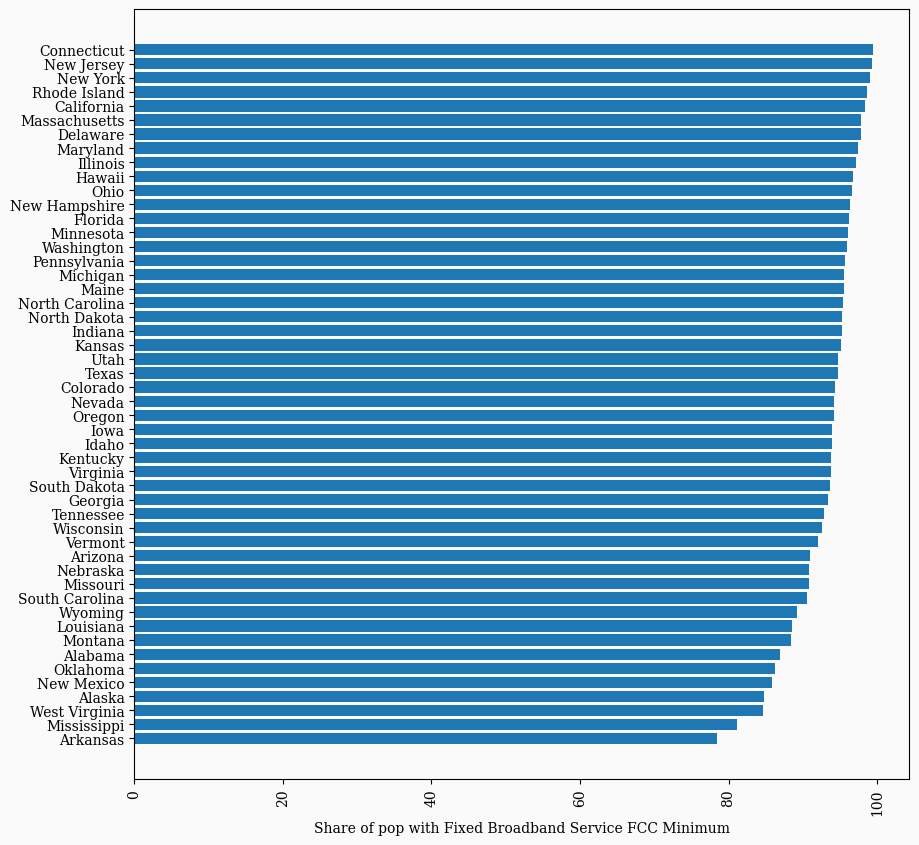

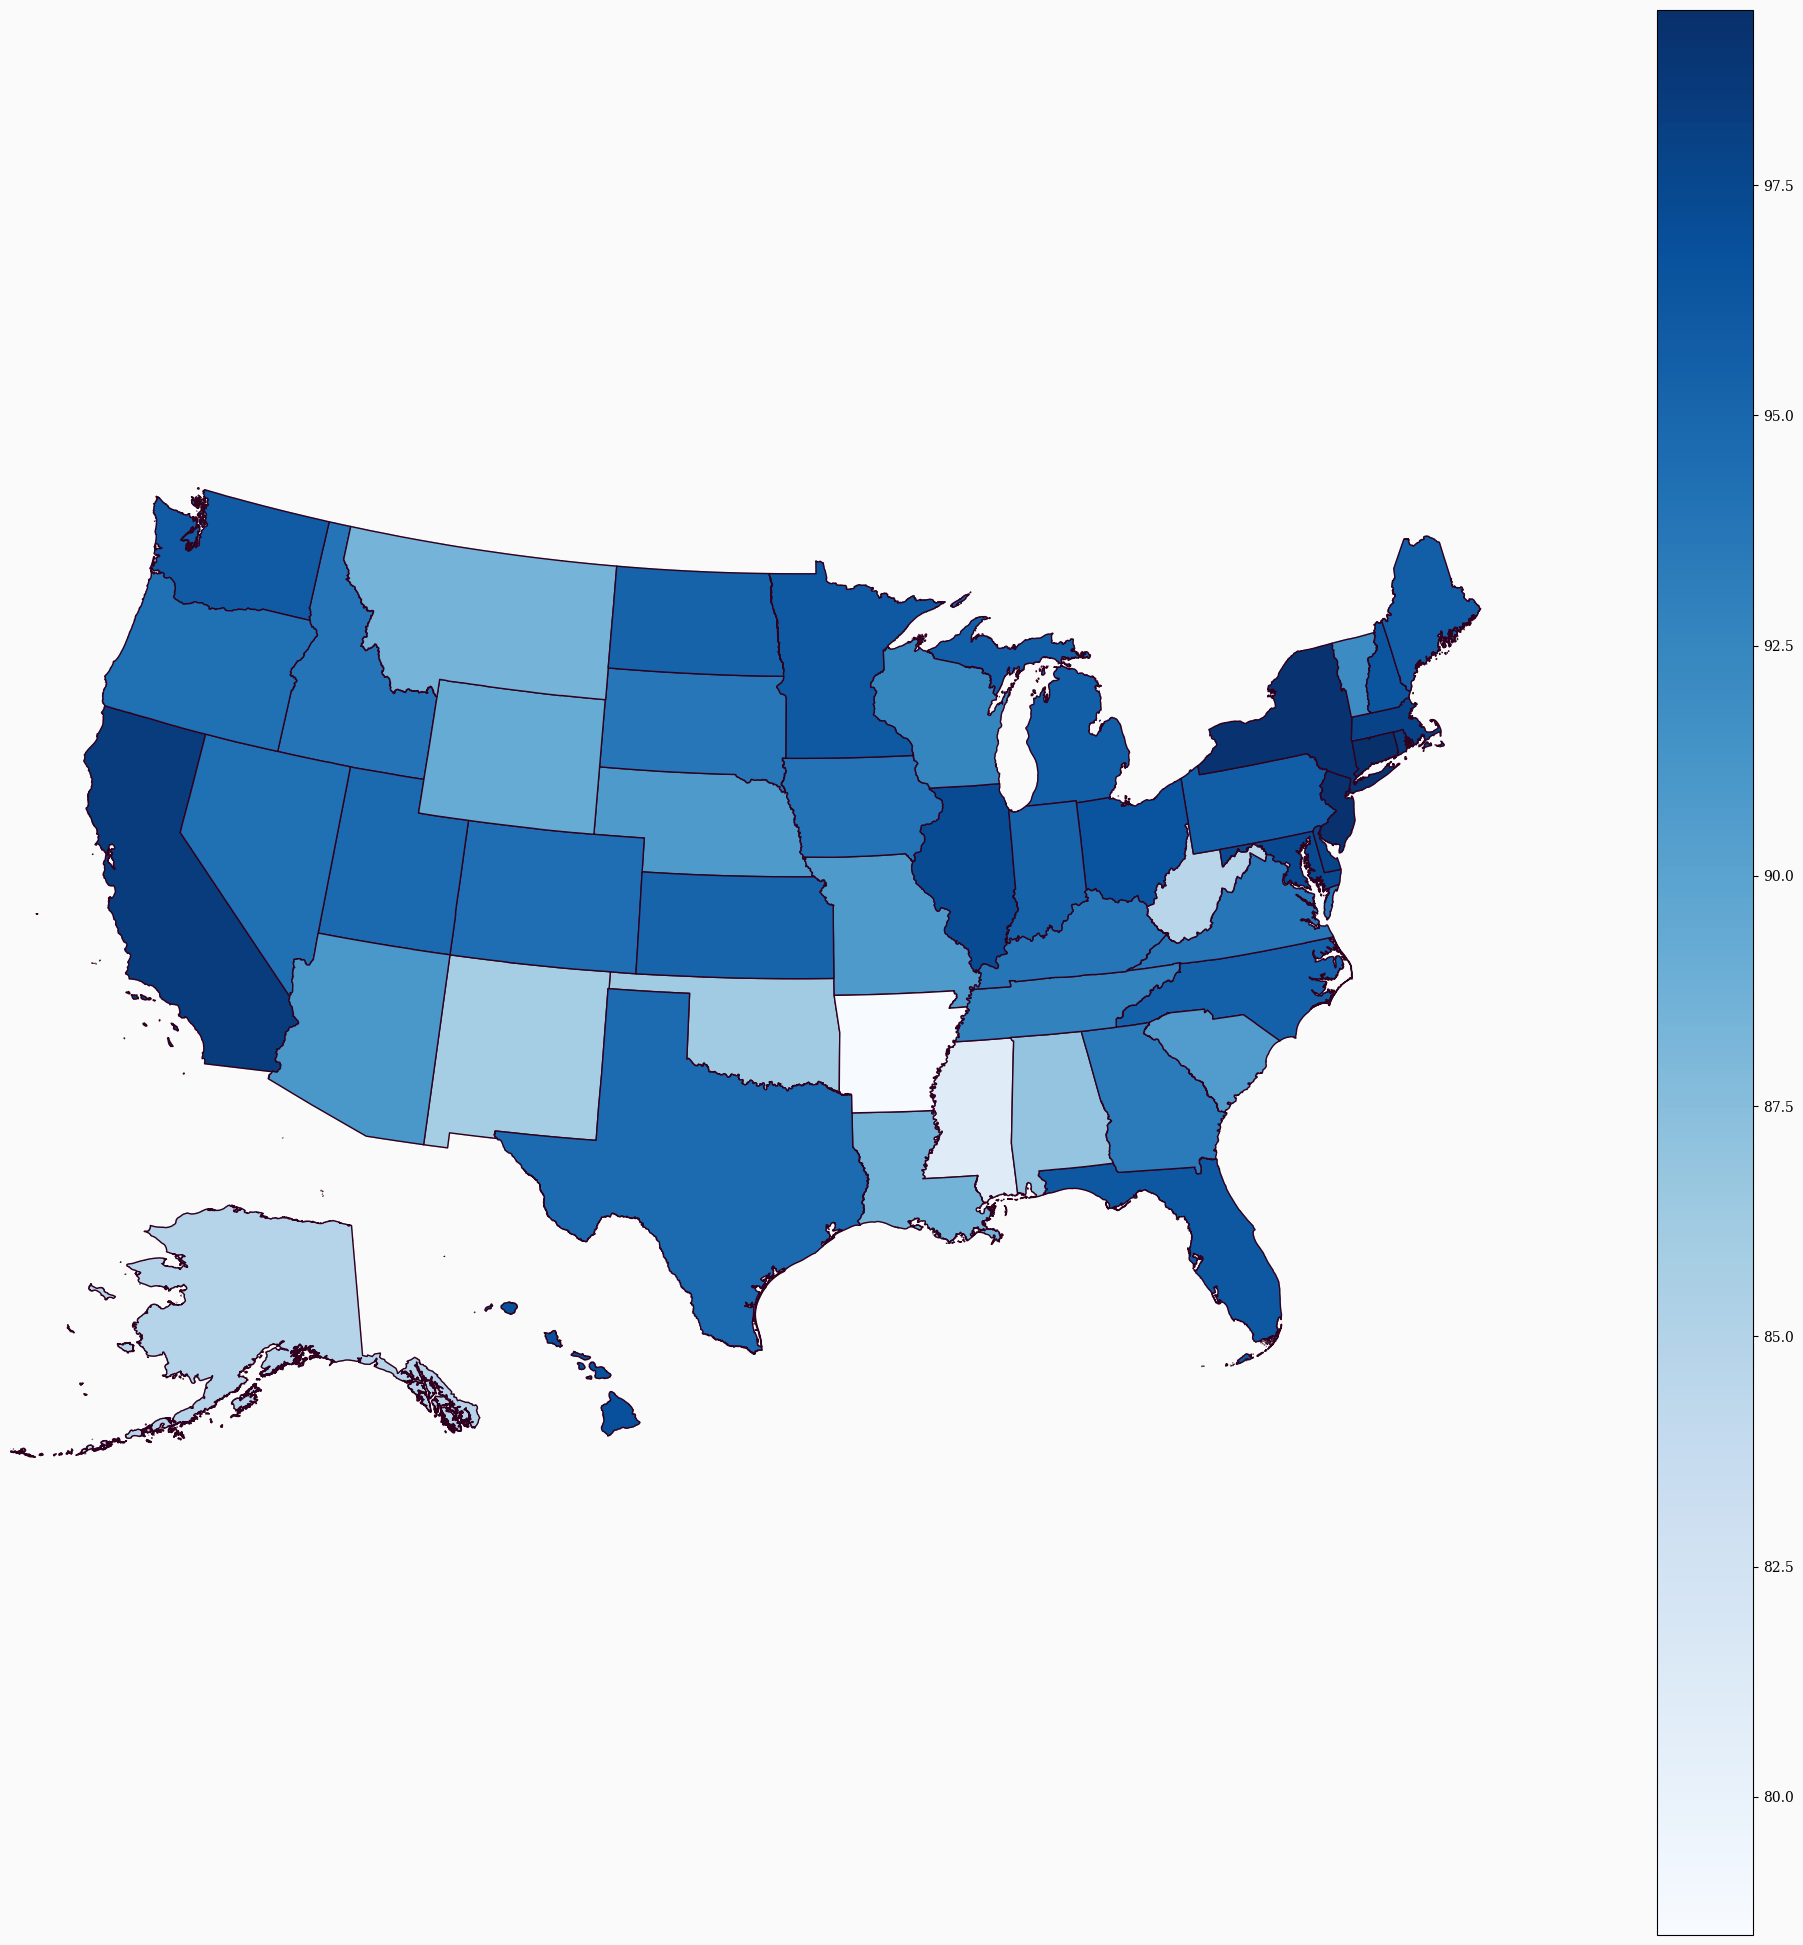

In [12]:
# graphs per state

graphMe = "Share of pop with Fixed Broadband Service FCC Minimum"


XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel(graphMe)
plt.ylabel("")

plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff",


ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

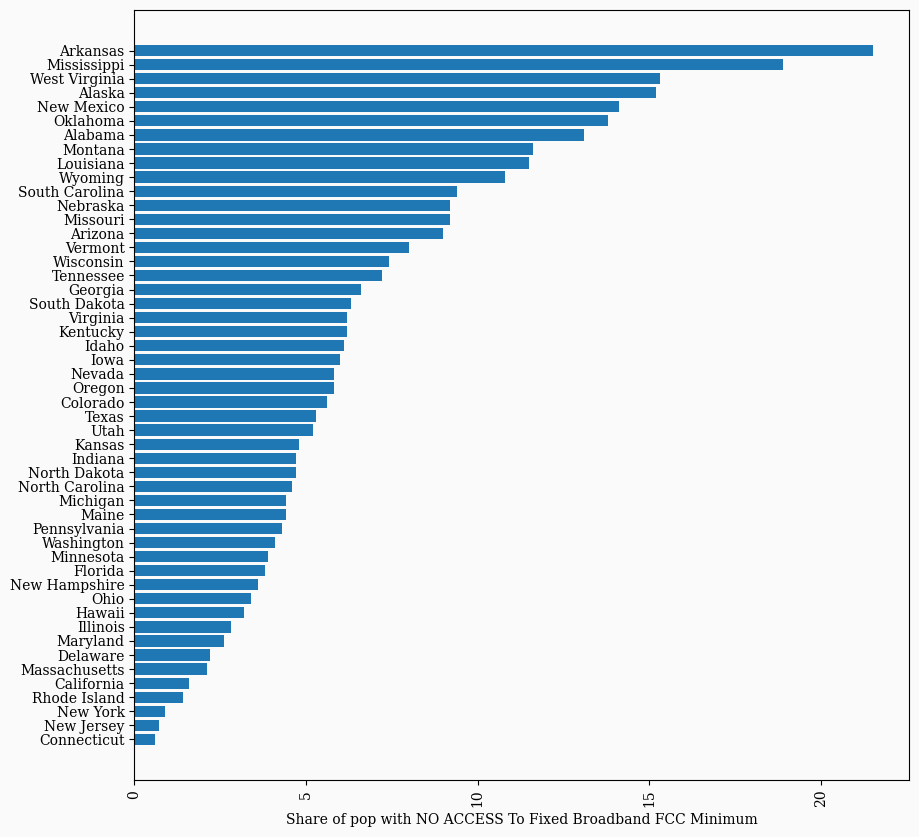

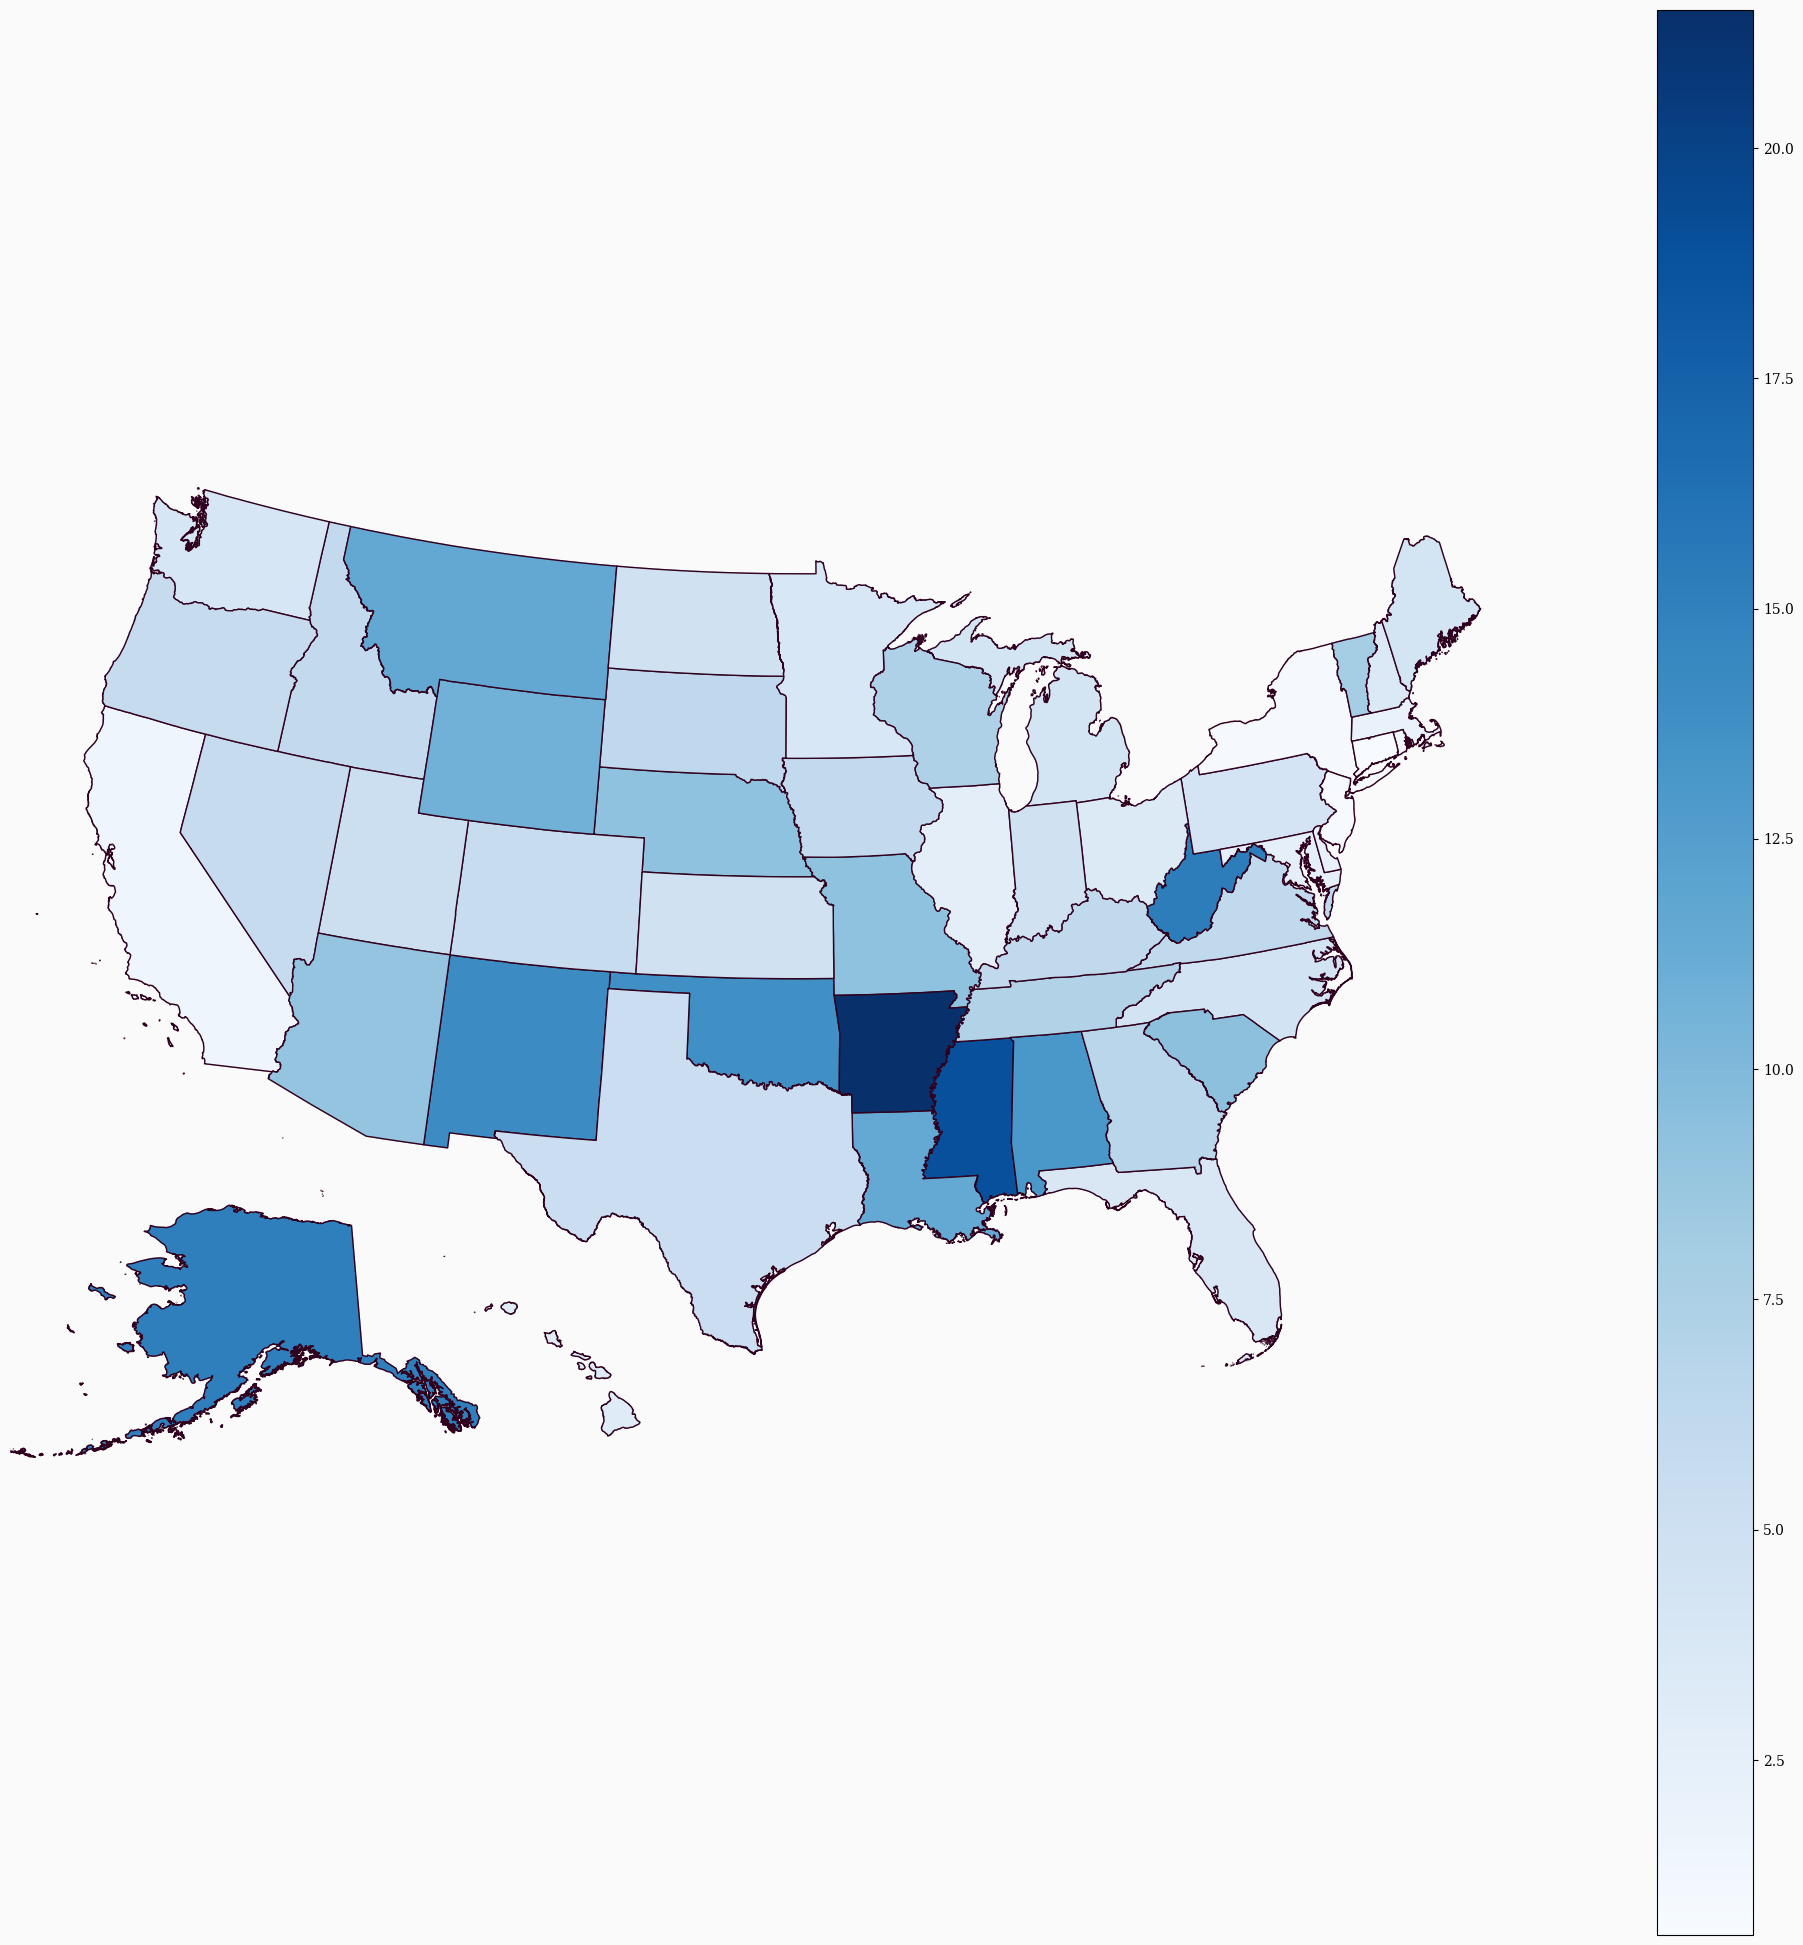

In [13]:
# graphs per state

graphMe = "Share of pop with NO ACCESS To Fixed Broadband FCC Minimum"


XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel(graphMe)
plt.ylabel("")

plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff",


ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

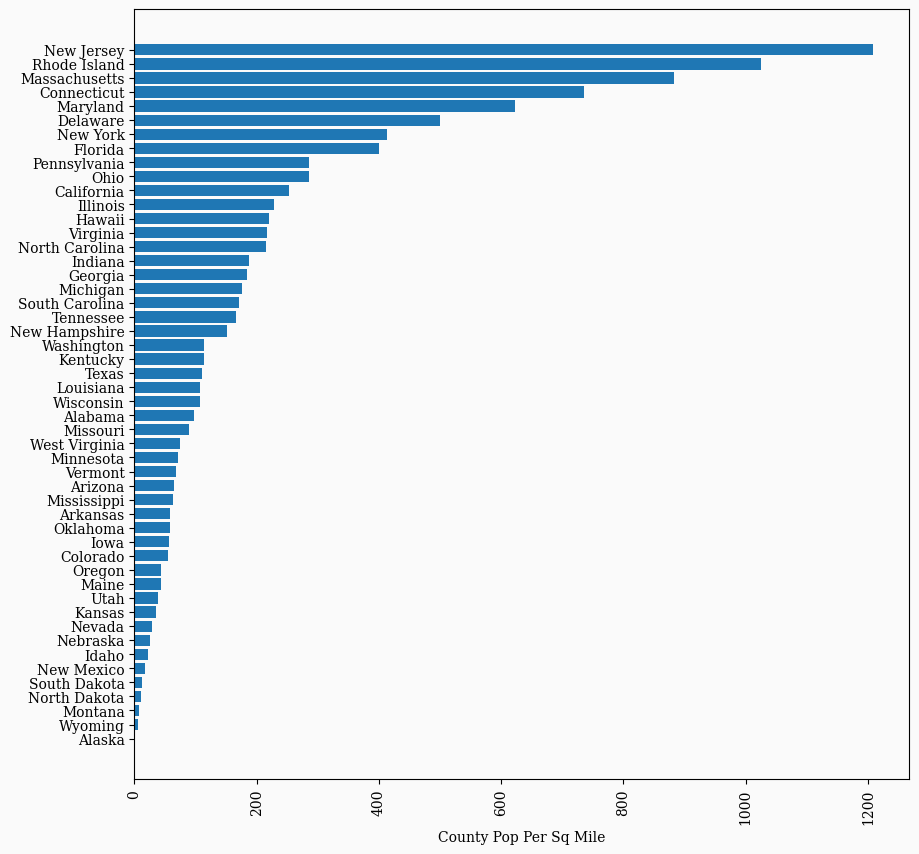

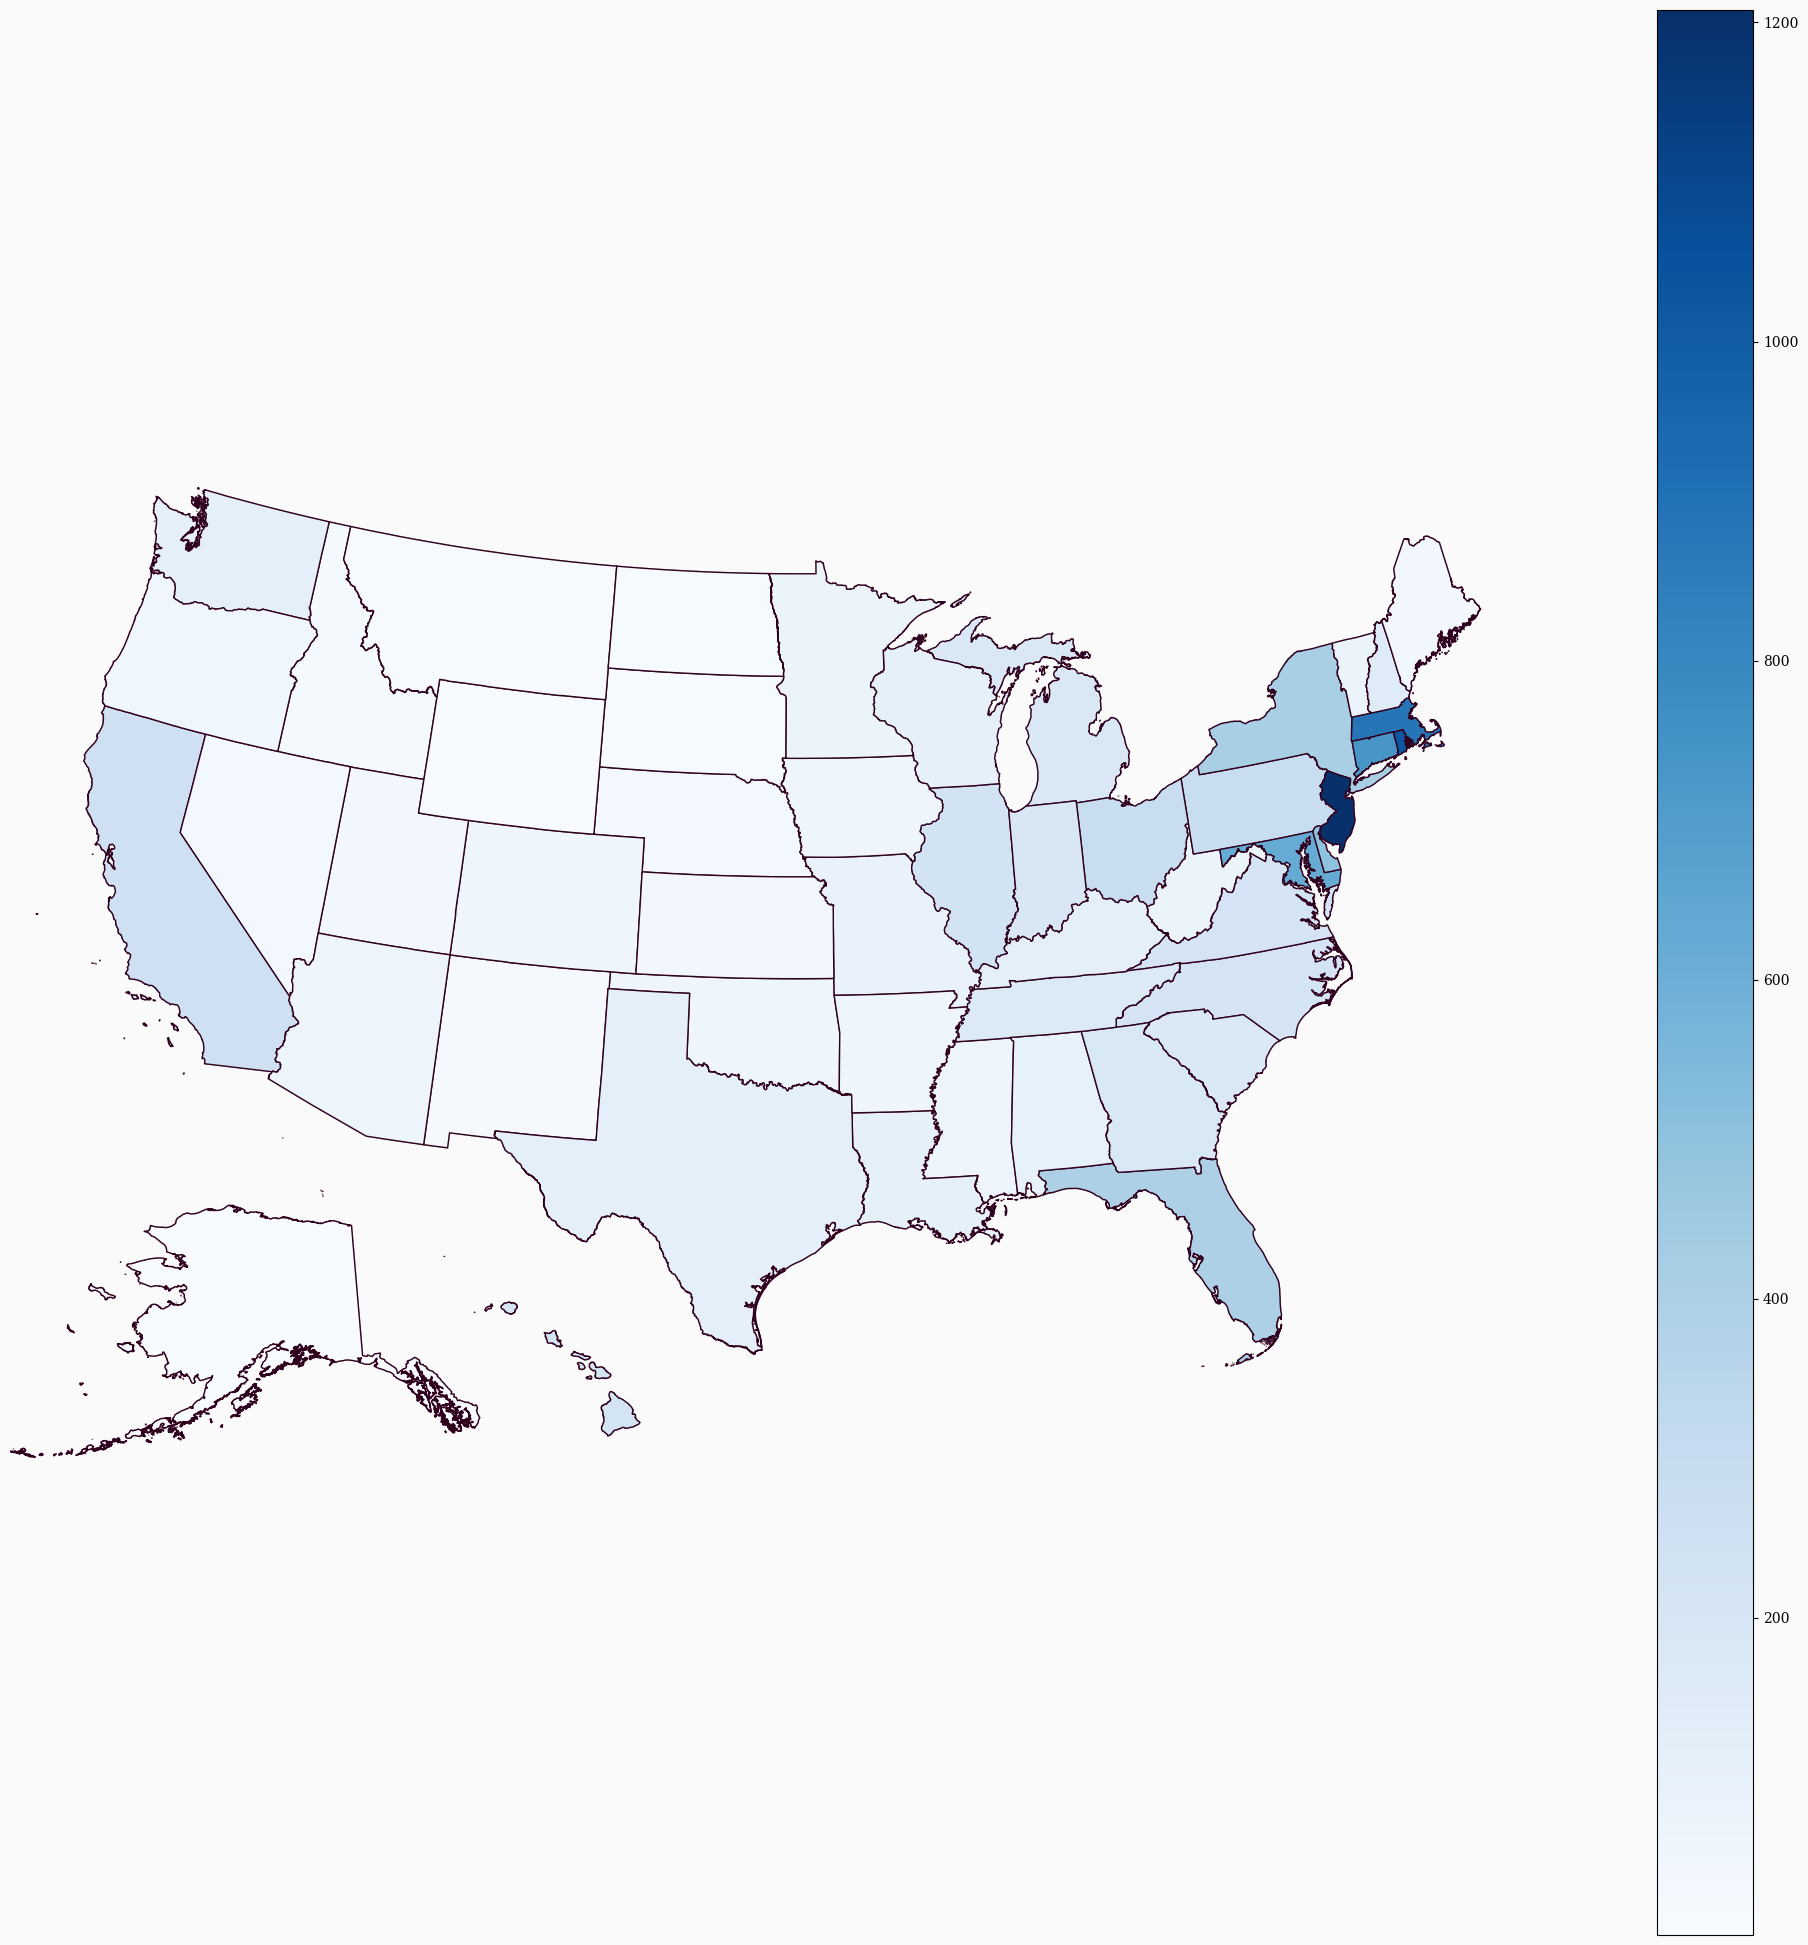

In [14]:
# graphs per state

graphMe = "County Pop Per Sq Mile"


XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel(graphMe)
plt.ylabel("")

plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff",


ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()

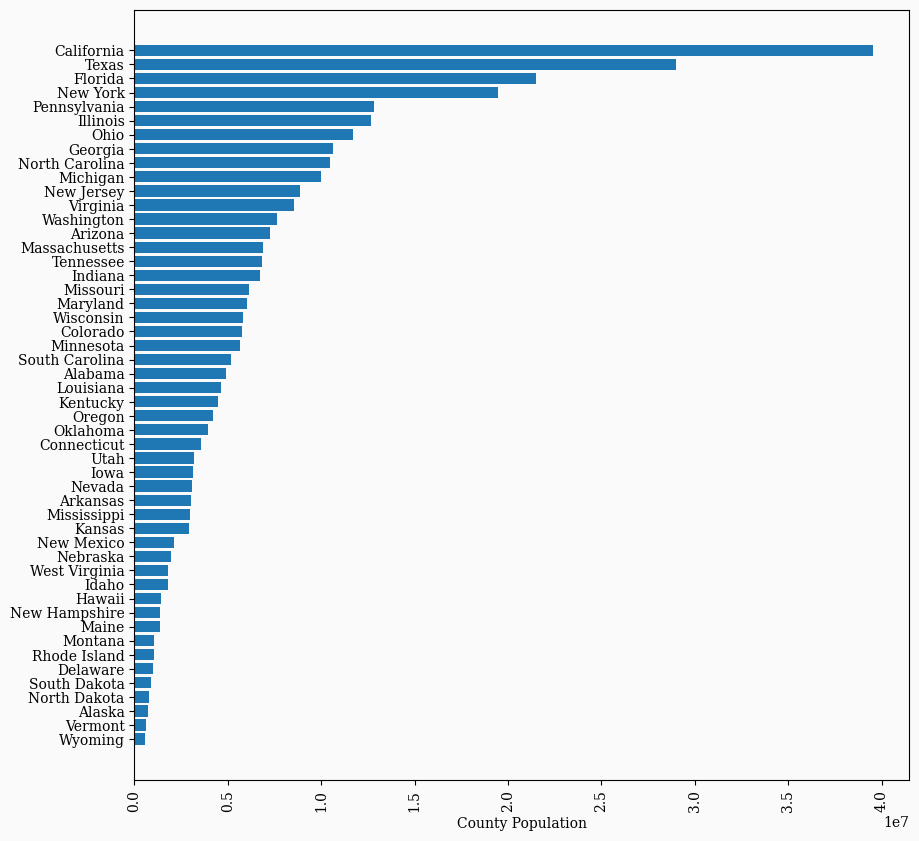

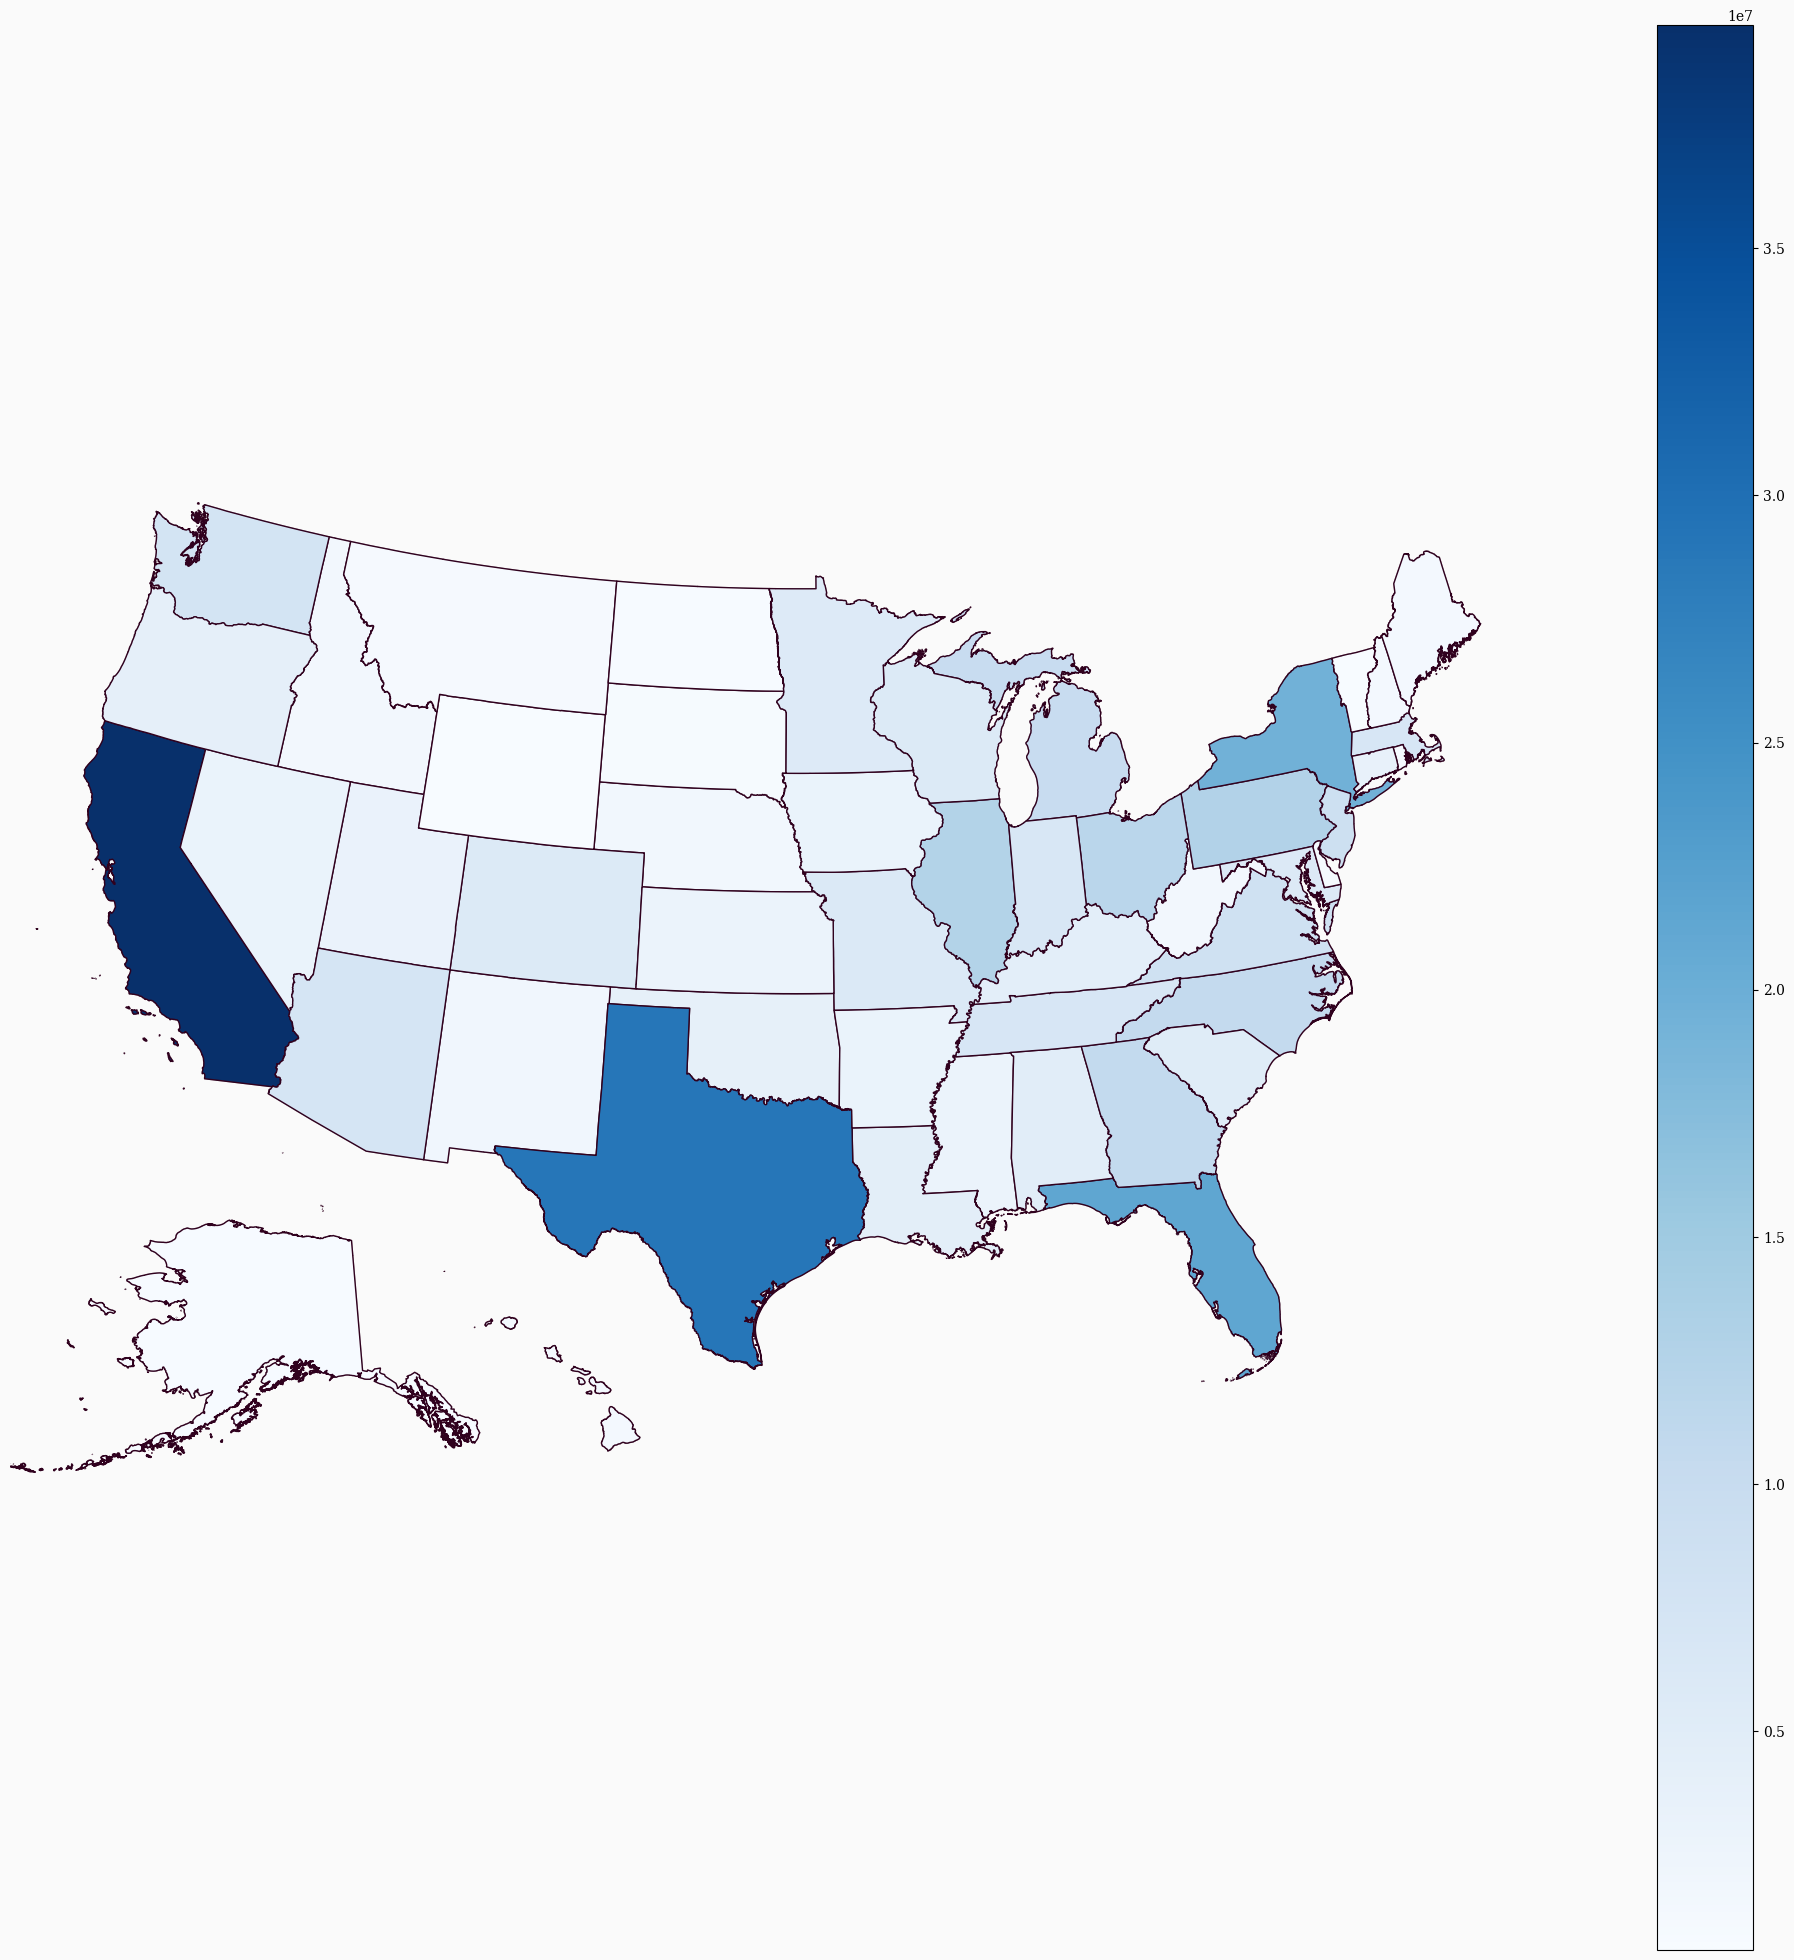

In [15]:
# graphs per state

graphMe = "County Population"


XY = states[['NAME', graphMe]]

graphXY=XY.sort_values(graphMe, ascending=True)

x = graphXY['NAME']
y = graphXY[graphMe]


fig = plt.figure(figsize = (10,10))

plt.barh(x,y)

# reverse y axis, gca() returns current Axes, [::-1] reverses the list
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.xlabel(graphMe)
plt.ylabel("")

plt.xticks(rotation=90, ha='center')

plt.show()

#________________________________________________________________________________
#________________________________________________________________________________

ax = states.plot(edgecolor=edge_color + "55", figsize=(25, 25))
#ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, linewidth=1, column=graphMe, 
            cmap='Blues', legend=True, figsize=(5, 5))  #color="#99d6ff",


ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()